# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'hoasa-besra'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

review    ac air_panas   bau  \
0                               kebersihan kurang...  neut      neut  neut   
1  sangat mengecewakan... hotel bad image, kebers...  neut      neut  neut   
2  Tempat nyaman bersih tapi tv terlalu tinggi ti...  neut      neut  neut   
3  semuanya bagus sesuai profile,dan harga promo ...  neut       neg  neut   
4  Tempat tidur sangat keras, bantal besar dan ke...   neg       neg  neut   

  general kebersihan linen service sunrise_meal    tv  wifi  
0    neut        neg  neut    neut         neut  neut  neut  
1    neut        neg  neut    neut         neut  neut  neut  
2    neut        pos  neut    neut         neut   neg  neut  
3     pos       neut  neut    neut         neut  neut  neut  
4    neut       neut   neg    neut         neut  neut  neut

In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    # if len(train_data) > 0:
    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

    # return None, None, None, None

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, model_num):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Setup Aspect Model
    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    ) 
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue
    
    # Setup Sentiment Model
    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)
    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare models
    aspect_model, aspect_optimizer = accelerator.prepare(aspect_model, aspect_optimizer)
    sentiment_model, sentiment_optimizer = accelerator.prepare(sentiment_model, sentiment_optimizer)

    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare train loaders
    aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    accelerator.wait_for_everyone()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{model_num+1}-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nModel {model_num+1} of aspect detection, Accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{model_num+1}-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{model_num+1}-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nModel {model_num+1} of sentiment analysis, accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{model_num+1}-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Model {model_num+1} - Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(result['accuracy'])
        metrics[1].append(result['f1_micro'])
        metrics[2].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def beta_score(p_pred_one, y_outcome, alpha=0.1, beta_p=3.0):
    """Calculates Beta score for a given probability p_pred_one and label y_outcome."""
    epsilon = 1e-9
    p_safe = np.clip(p_pred_one, epsilon, 1.0 - epsilon)

    if y_outcome == 1:
        arg1_a = alpha
        arg2_b_p1 = beta_p + 1
        arg3_a_p = alpha + p_safe
        arg4_b_p1_m_p = beta_p + 1 - p_safe
        if not (arg1_a > 0 and arg2_b_p1 > 0 and arg3_a_p > 0 and arg4_b_p1_m_p > 0):
            return -1e9
        return -betaln(arg1_a, arg2_b_p1) + betaln(arg3_a_p, arg4_b_p1_m_p)
    elif y_outcome == 0:
        arg1_a_p1 = alpha + 1
        arg2_b = beta_p
        arg3_a_p1_m_p = alpha + 1 - p_safe
        arg4_b_p = beta_p + p_safe
        if not (arg1_a_p1 > 0 and arg2_b > 0 and arg3_a_p1_m_p > 0 and arg4_b_p > 0):
            return -1e9
        return -betaln(arg1_a_p1, arg2_b) + betaln(arg3_a_p1_m_p, arg4_b_p)
    else:
        raise ValueError("Invalid label: y_outcome must be 0 or 1.")

def calculate_expected_beta_score(p_one, alpha, beta_p):
    """
    Calculates E[S(P,Y)] = P(Y=1|P)S(P,1) + P(Y=0|P)S(P,0) [cite: 54, 65]
    This is related to the 'gp' (green line) in Figure 1 of the paper.
    """
    score_if_one = beta_score(p_one, 1, alpha, beta_p)
    score_if_zero = beta_score(p_one, 0, alpha, beta_p)
    expected_score = p_one * score_if_one + (1.0 - p_one) * score_if_zero
    return expected_score

def get_ensemble_predictions_for_batch(models_ensemble, input_ids, attn_mask, device):
    """
    Gets predictions from the ensemble for a given batch.
    Returns:
        avg_probs (Tensor): Average probabilities [batch_size, num_classes].
        indiv_probs_list (List[Tensor]): List of probabilities for each model.
    """
    indiv_probs_gpu_list = []
    with torch.no_grad():
        for model_instance in models_ensemble: 
            model_instance.eval()
            model_instance.to(device)
            outputs = model_instance(input_ids.to(device), attention_mask=attn_mask.to(device))
            probs = torch.sigmoid(outputs.logits)
            indiv_probs_gpu_list.append(probs)

        if not indiv_probs_gpu_list:
            return torch.empty(0, device=device), []

        indiv_probs_stack = torch.stack(indiv_probs_gpu_list)
        avg_probs = torch.mean(indiv_probs_stack, dim=0)
    
    return avg_probs, indiv_probs_gpu_list

def calculate_score_change(cand_avg_probs, est_avg_probs, cand_indiv_probs_list_concatenated, est_indiv_probs_list_concatenated, num_classes, alpha_param=0.1, beta_param=3.0):
    cand_prob_L_all_cls = cand_avg_probs
    cand_prob_models_all_cls = [m_probs for m_probs in cand_indiv_probs_list_concatenated]

    current_cand_score = 0.0 

    # --- Middle loop: Iterate through estimation samples x' from Estimation Pool X ---
    for i_est in range(len(est_avg_probs)): # For each estimation sample x'
        est_prob_L_all_cls = est_avg_probs[i_est]
        est_prob_models_all_cls = [m_probs[i_est] for m_probs in est_indiv_probs_list_concatenated]

        # Calculate estimated beta score
        est_score_L_sum_k = 0.0
        for k_est_cls_idx in range(num_classes):
            prob_one_L_est_k = est_prob_L_all_cls[k_est_cls_idx].item()
            est_score_L_sum_k += calculate_expected_beta_score(prob_one_L_est_k, alpha_param, beta_param)
        
        # Ensemble reweighting
        delta_Q_est = 0.0 
        for j_cand_cls_idx in range(num_classes): # For each class j of candidate x
            avg_est_score_Lplus_for_j = 0.0
            for cand_hypo_label_y_j in [0, 1]: 
                prob_one_cand_j_L = cand_prob_L_all_cls[j_cand_cls_idx].item()
                prob_cand_j_hypo_L = prob_one_cand_j_L if cand_hypo_label_y_j == 1 else (1.0 - prob_one_cand_j_L)

                # Calculate weights for each model based on the candidate's hypothetical label
                model_weights = [] 
                for model_idx_loop in range(3):
                    prob_one_cand_j_model_e = cand_prob_models_all_cls[model_idx_loop][j_cand_cls_idx].item()
                    prob_cand_j_hypo_model_e = prob_one_cand_j_model_e if cand_hypo_label_y_j == 1 else (1.0 - prob_one_cand_j_model_e)
                    model_weights.append(prob_cand_j_hypo_model_e)
                
                # Normalize model weights
                sum_model_weights = sum(model_weights)
                if sum_model_weights < 1e-9:
                    norm_model_weights = [1.0 / 3] * 3
                else:
                    norm_model_weights = [w / sum_model_weights for w in model_weights]

                # Calculate average expected score for L+ given x' and class j
                current_est_score_Lplus_sum_k = 0.0
                prob_one_Lplus_est_k = 0.0
                for model_idx_loop_2 in range(3): 
                    prob_one_model_e_est_k = est_prob_models_all_cls[model_idx_loop_2][j_cand_cls_idx].item()
                    prob_one_Lplus_est_k += norm_model_weights[model_idx_loop_2] * prob_one_model_e_est_k
                    
                current_est_score_Lplus_sum_k += calculate_expected_beta_score(prob_one_Lplus_est_k, alpha_param, beta_param)
                
                avg_est_score_Lplus_for_j += prob_cand_j_hypo_L * current_est_score_Lplus_sum_k
        
            delta_Q_est += (avg_est_score_Lplus_for_j - est_score_L_sum_k)
        current_cand_score += delta_Q_est

    return current_cand_score

In [20]:
def besra_sampling(
    aspect_models, 
    sentiment_models,    
    unlabeled_pool_data, 
    train_indices,
    remaining_indices,
    estimation_pool_data,
    tokenizer,
    num_classes,
    sampling_dur,   
    new_samples,
    trials, 
    alpha_param=0.1,
    beta_param=3.0,
    n_clusters=min_increment,
):
    # Set n_clusters to min_increment if not provided
    if n_clusters is None:
        n_clusters = min_increment

    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    ul_aspect_dataset = AspectDetectionDataset(
        unlabeled_pool_data, 
        [['neut' for i in range(num_classes[0])] for x in range(len(unlabeled_pool_data))], 
        label_mapping,
        tokenizer, 
        max_length=sequence_length
    ) 
    ul_aspect_loader = DataLoader(ul_aspect_dataset, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=False)

    current_train_size = len(train_indices)

    est_aspect_dataset = AspectDetectionDataset(
        estimation_pool_data, 
        [['neut' for i in range(num_classes[0])] for x in range(len(estimation_pool_data))], 
        label_mapping,
        tokenizer, 
        max_length=sequence_length
    ) 
    est_aspect_loader = DataLoader(est_aspect_dataset, batch_size=len(est_aspect_dataset), num_workers=4, pin_memory=True, shuffle=False)

    for aspect_model in aspect_models:
        aspect_model.to(device)
        aspect_model.eval()

    for sentiment_model in sentiment_models:
        sentiment_model.to(device)
        sentiment_model.eval()

    start_time = time.time()

    all_aspect_est_avg_probs = []
    all_aspect_est_indiv_probs = [] 

    all_aspect_cand_avg_probs = []
    all_aspect_cand_indiv_probs = []

    all_sentiment_est_avg_probs = []
    all_sentiment_est_indiv_probs = []

    all_sentiment_ul_avg_probs = []
    all_sentiment_ul_indiv_probs = []

    aspect_outputs = {}
    sentiment_outputs = {}

    ul_aspects = []
    ul_data = []
    ul_labels = []
    ul_indices = []

    est_aspects = []
    est_data = []
    est_labels = []
    est_indices = []

    # inference on estimation pool
    for est_b_idx, est_batch in enumerate(est_aspect_loader):
        est_ids = est_batch['input_ids']
        est_mask = est_batch['attention_mask']

        est_avg_probs, est_indiv_prob_list = get_ensemble_predictions_for_batch(aspect_models, est_ids, est_mask, device)
        all_aspect_est_avg_probs.append(est_avg_probs)
        
        # Extend the list with the tensors for each model in the current batch
        if not all_aspect_est_indiv_probs: # First batch, initialize list of lists
            for _ in range(len(est_indiv_prob_list)):
                all_aspect_est_indiv_probs.append([])
        for model_idx, probs in enumerate(est_indiv_prob_list):
            all_aspect_est_indiv_probs[model_idx].append(probs)

        for i in range(len(est_avg_probs)):
            for class_idx in range(est_avg_probs.shape[1]):
                if int(est_avg_probs[i][class_idx].round()) != 1:
                    est_aspects.append(aspect_list[class_idx])
                    est_data.append(est_batch['ori_text'][i])
                    est_labels.append(est_batch['ori_label'][i][class_idx])
                    est_indices.append(est_batch['ori_indices'][i])        

    # Concatenate all collected probabilities
    all_aspect_est_avg_probs = torch.cat(all_aspect_est_avg_probs, dim=0)
    all_aspect_est_indiv_probs = [torch.cat(model_probs, dim=0) for model_probs in all_aspect_est_indiv_probs] 
    
    # Iterate through unlabeled aspect dataset
    for cand_b_idx, cand_batch in enumerate(ul_aspect_loader):
        cand_ids = cand_batch['input_ids']
        cand_mask = cand_batch['attention_mask']

        # P(y_k|L,x) and P(y_k|theta_e,x) for current batch of candidates
        cand_avg_prob, cand_indiv_prob_list = get_ensemble_predictions_for_batch(aspect_models, cand_ids, cand_mask, device)
        all_aspect_cand_avg_probs.append(cand_avg_prob)
        
        # Extend the list with the tensors for each model in the current batch
        if not all_aspect_cand_indiv_probs: # First batch, initialize list of lists
            for _ in range(len(cand_indiv_prob_list)):
                all_aspect_cand_indiv_probs.append([])
        for model_idx, probs in enumerate(cand_indiv_prob_list):
            all_aspect_cand_indiv_probs[model_idx].append(probs)

        for i in range(len(cand_avg_prob)):
            score_diff = calculate_score_change(
                cand_avg_prob[i], 
                all_aspect_est_avg_probs, 
                [model_probs[i] for model_probs in cand_indiv_prob_list], 
                all_aspect_est_indiv_probs, 
                num_classes[0], 
                alpha_param, 
                beta_param
            )

            for class_idx in range(cand_avg_prob.shape[1]):
                if int(cand_avg_prob[i][class_idx].round()) != 1:
                    ul_aspects.append(aspect_list[class_idx])
                    ul_data.append(cand_batch['ori_text'][i])
                    ul_labels.append(cand_batch['ori_label'][i][class_idx])
                    ul_indices.append(cand_batch['ori_indices'][i])

            aspect_outputs[cand_batch['ori_indices'][i].item()] = score_diff
            
    all_aspect_cand_avg_probs = torch.cat(all_aspect_cand_avg_probs, dim=0)
    all_aspect_cand_indiv_probs = [torch.cat(model_probs, dim=0) for model_probs in all_aspect_cand_indiv_probs]

    est_sentiment_dataset = SentimentAnalysisDataset(est_data, est_labels, est_aspects, est_indices, label_mapping, tokenizer, max_length=sequence_length)
    est_sentiment_loader = torch.utils.data.DataLoader(
        est_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    ul_sentiment_dataset = SentimentAnalysisDataset(ul_data, ul_labels, ul_aspects, ul_indices, label_mapping, tokenizer, max_length=sequence_length)
    ul_sentiment_loader = torch.utils.data.DataLoader(
        ul_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # inference on estimation pool for sentiment analysis
    for est_b_idx, est_batch in enumerate(est_sentiment_loader):
        est_ids = est_batch['input_ids']
        est_mask = est_batch['attention_mask']

        est_avg_probs, est_indiv_prob_list = get_ensemble_predictions_for_batch(sentiment_models, est_ids, est_mask, device)
        all_sentiment_est_avg_probs.append(est_avg_probs)
        
        # Extend the list with the tensors for each model in the current batch
        if not all_sentiment_est_indiv_probs: # First batch, initialize list of lists
            for _ in range(len(est_indiv_prob_list)):
                all_sentiment_est_indiv_probs.append([])
        for model_idx, probs in enumerate(est_indiv_prob_list):
            all_sentiment_est_indiv_probs[model_idx].append(probs)

    all_sentiment_est_avg_probs = torch.cat(all_sentiment_est_avg_probs, dim=0)
    all_sentiment_est_indiv_probs = [torch.cat(model_probs, dim=0) for model_probs in all_sentiment_est_indiv_probs] 

    # Iterate through unlabeled sentiment dataset
    for cand_b_idx, cand_batch in enumerate(ul_sentiment_loader):
        cand_ids = cand_batch['input_ids']
        cand_mask = cand_batch['attention_mask']

        # P(y_k|L,x) and P(y_k|theta_e,x) for current batch of candidates
        cand_avg_prob, cand_indiv_prob_list = get_ensemble_predictions_for_batch(sentiment_models, cand_ids, cand_mask, device)
        all_sentiment_ul_avg_probs.append(cand_avg_prob)
        
        # Extend the list with the tensors for each model in the current batch
        if not all_sentiment_ul_indiv_probs: 
            for _ in range(len(cand_indiv_prob_list)):
                all_sentiment_ul_indiv_probs.append([])
        for model_idx, probs in enumerate(cand_indiv_prob_list):
            all_sentiment_ul_indiv_probs[model_idx].append(probs)

        for j in range(len(cand_avg_prob)):
            score_diff = calculate_score_change(
                cand_avg_prob[j], 
                all_sentiment_est_avg_probs, 
                [model_probs[j] for model_probs in cand_indiv_prob_list], 
                all_sentiment_est_indiv_probs, 
                num_classes[1], 
                alpha_param, 
                beta_param
            )

            ori_index = cand_batch['ori_indices'][j].item()
            if ori_index in sentiment_outputs.keys():
                sentiment_outputs[ori_index].append(score_diff)
            else:
                sentiment_outputs[ori_index] = [score_diff]
    
    accelerator.wait_for_everyone() 
                
    # --- K-Means Clustering and Selection ---
    # Ensure all processes sync before main process continues with selection
    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))
        if len(ul_sentiment_dataset) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = (np.mean(np.array(val)) + aspect_outputs[key]) / 2
        candidate_scores = np.array(list(aspect_outputs.values())).reshape(-1, 1)
    
        candidate_scores = np.array(candidate_scores)
        candidate_scores = candidate_scores.reshape(-1, 1)
    
        accelerator.print(f"BESRA Uncertainty Score Threshold {np.percentile(candidate_scores, 90)}")
    
        target_samples = math.ceil(0.1 * len(unlabeled_pool_data))
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size
    
        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
    
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(candidate_scores)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(candidate_scores[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)
    
            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'ac': [y_train[i][0] for i in temp],
                    'air_panas': [y_train[i][1] for i in temp],
                    'bau': [y_train[i][2] for i in temp],
                    'general': [y_train[i][3] for i in temp],
                    'kebersihan': [y_train[i][4] for i in temp],
                    'linen': [y_train[i][5] for i in temp],
                    'service': [y_train[i][6] for i in temp],
                    'sunrise_meal': [y_train[i][7] for i in temp],
                    'tv': [y_train[i][8] for i in temp],
                    'wifi': [y_train[i][9] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])
    
            # threshold_data = pd.DataFrame({
            #     'Threshold': thresholds
            # })
            # threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_aspect_accuracies = manager.list()
        model_aspect_f1_micros = manager.list()
        model_aspect_f1_macros = manager.list()
        model_sentiment_accuracies = manager.list()
        model_sentiment_f1_micros = manager.list()
        model_sentiment_f1_macros = manager.list()
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()

        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (
                current_train_size, 
                train_indices, 
                (model_aspect_accuracies, model_aspect_f1_micros, model_aspect_f1_macros), 
                (model_sentiment_accuracies, model_sentiment_f1_micros, model_sentiment_f1_macros),
                (model_accuracies, model_f1_micros, model_f1_macros), 
                i,
                j
            )
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        aspect_accuracies.append(np.mean(model_aspect_accuracies))
        aspect_f1_micros.append(np.mean(model_aspect_f1_micros))
        aspect_f1_macros.append(np.mean(model_aspect_f1_macros))
        sentiment_accuracies.append(np.mean(model_sentiment_accuracies))
        sentiment_f1_micros.append(np.mean(model_sentiment_f1_micros))
        sentiment_f1_macros.append(np.mean(model_sentiment_f1_macros))
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_models = []
        sentiment_models = []
        for j in range(3):
            aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{j+1}-{percentage}')
            sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{j+1}-{percentage}')
            
            aspect_models.append(aspect_model)
            sentiment_models.append(sentiment_model)
    
        # Perform query strategy to select new samples
        estimation_pool_indices = np.random.choice(remaining_indices, size=min(16, int(0.1 * len(remaining_indices))), replace=False).tolist()
        estimation_pool_data = [X_train[i] for i in estimation_pool_indices]
        new_samples = manager.list()
        sampling_args = (
            aspect_models, 
            sentiment_models, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            estimation_pool_data,
            tokenizer,
            (10, 2),
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    for j in range(3):
        set_seed(seed[j])
        args = (
            current_train_size, 
            train_indices, 
            (model_aspect_accuracies, model_aspect_f1_micros, model_aspect_f1_macros), 
            (model_sentiment_accuracies, model_sentiment_f1_micros, model_sentiment_f1_macros),
            (model_accuracies, model_f1_micros, model_f1_macros), 
            i,
            j
        )
        notebook_launcher(train_model, args, num_processes=2)

    data_used.append(current_train_size)
    aspect_accuracies.append(np.mean(model_aspect_accuracies))
    aspect_f1_micros.append(np.mean(model_aspect_f1_micros))
    aspect_f1_macros.append(np.mean(model_aspect_f1_macros))
    sentiment_accuracies.append(np.mean(model_sentiment_accuracies))
    sentiment_f1_micros.append(np.mean(model_sentiment_f1_micros))
    sentiment_f1_macros.append(np.mean(model_sentiment_f1_macros))
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")

    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 61, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5969, Accuracy: 0.8003, F1 Micro: 0.8884, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4893, Accuracy: 0.8054, F1 Micro: 0.8899, F1 Macro: 0.8807
Epoch 3/10, Train Loss: 0.4453, Accuracy: 0.8012, F1 Micro: 0.8895, F1 Macro: 0.885
Epoch 4/10, Train Loss: 0.4289, Accuracy: 0.8016, F1 Micro: 0.8897, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3875, Accuracy: 0.8069, F1 Micro: 0.8922, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.398, Accuracy: 0.8108, F1 Micro: 0.8932, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3841, Accuracy: 0.8167, F1 Micro: 0.8963, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3487, Accuracy: 0.8328, F1 Micro: 0.9039, F1 Macro: 0.8973
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3313, Accuracy: 0.8389, F1 Micro: 0.9071, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6477, Accuracy: 0.7927, F1 Micro: 0.8839, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5075, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4503, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8854
Epoch 4/10, Train Loss: 0.4347, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.3974, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4087, Accuracy: 0.8031, F1 Micro: 0.8904, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4025, Accuracy: 0.808, F1 Micro: 0.892, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3704, Accuracy: 0.8116, F1 Micro: 0.8936, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3498, Accuracy: 0.8217, F1 Micro: 0.8982, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.603, Accuracy: 0.8019, F1 Micro: 0.8898, F1 Macro: 0.8852
Epoch 2/10, Train Loss: 0.4851, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 3/10, Train Loss: 0.4438, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 4/10, Train Loss: 0.4285, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3889, Accuracy: 0.8017, F1 Micro: 0.8899, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3934, Accuracy: 0.8078, F1 Micro: 0.8924, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3845, Accuracy: 0.816, F1 Micro: 0.8964, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3532, Accuracy: 0.8321, F1 Micro: 0.9043, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3343, Accuracy: 0.8439, F1 Micro: 0.9103, F1 Macro: 0.9052
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5354, Accuracy: 0.803, F1 Micro: 0.8897, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4527, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4293, Accuracy: 0.8201, F1 Micro: 0.8983, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3843, Accuracy: 0.8467, F1 Micro: 0.9114, F1 Macro: 0.9061
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3591, Accuracy: 0.8693, F1 Micro: 0.9233, F1 Macro: 0.918
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3046, Accuracy: 0.8832, F1 Micro: 0.931, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.273, Accuracy: 0.9054, F1 Micro: 0.9432, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2339, Accuracy: 0.9135, F1 Micro: 0.9477, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5769, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8853
Epoch 2/10, Train Loss: 0.4596, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4403, Accuracy: 0.8059, F1 Micro: 0.8915, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4067, Accuracy: 0.8236, F1 Micro: 0.8992, F1 Macro: 0.8921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3874, Accuracy: 0.8635, F1 Micro: 0.9195, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3323, Accuracy: 0.8776, F1 Micro: 0.9278, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2945, Accuracy: 0.8955, F1 Micro: 0.9372, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2585, Accuracy: 0.9144, F1 Micro: 0.948, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2342, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5391, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4526, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4251, Accuracy: 0.8198, F1 Micro: 0.8982, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3797, Accuracy: 0.8562, F1 Micro: 0.9165, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3513, Accuracy: 0.8769, F1 Micro: 0.9274, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.299, Accuracy: 0.8882, F1 Micro: 0.9339, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2665, Accuracy: 0.9036, F1 Micro: 0.9422, F1 Macro: 0.9385
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.229, Accuracy: 0.9184, F1 Micro: 0.9502, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.207

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4369, Accuracy: 0.8203, F1 Micro: 0.8983, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3913, Accuracy: 0.8615, F1 Micro: 0.9195, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3307, Accuracy: 0.8828, F1 Micro: 0.931, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2678, Accuracy: 0.9137, F1 Micro: 0.9483, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.221, Accuracy: 0.922, F1 Micro: 0.9531, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1972, Accuracy: 0.9304, F1 Micro: 0.9578, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1687, Accuracy: 0.9316, F1 Micro: 0.9584, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Epoch 1/10, Train Loss: 0.5393, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4448, Accuracy: 0.8062, F1 Micro: 0.8918, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4147, Accuracy: 0.8457, F1 Micro: 0.9113, F1 Macro: 0.9061
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3524, Accuracy: 0.8811, F1 Micro: 0.9296, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2919, Accuracy: 0.9149, F1 Micro: 0.9486, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2405, Accuracy: 0.9161, F1 Micro: 0.9498, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2159, Accuracy: 0.9318, F1 Micro: 0.9582, F1 Macro: 0.9555
Epoch 8/10, Train Loss: 0.1841, Accuracy: 0.929, F1 Micro: 0.9569, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1566, Accuracy: 0.9366, F1 Micro: 0.9614, F1 Macro: 0.9589
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5186, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4376, Accuracy: 0.8097, F1 Micro: 0.8938, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3899, Accuracy: 0.8653, F1 Micro: 0.9215, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3255, Accuracy: 0.8892, F1 Micro: 0.9345, F1 Macro: 0.9311
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.262, Accuracy: 0.921, F1 Micro: 0.9522, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2203, Accuracy: 0.9286, F1 Micro: 0.9569, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1901, Accuracy: 0.9342, F1 Micro: 0.9598, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1639, Accuracy: 0.9391, F1 Micro: 0.9628, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5055, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4305, Accuracy: 0.8432, F1 Micro: 0.91, F1 Macro: 0.9055
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3508, Accuracy: 0.8837, F1 Micro: 0.9316, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2765, Accuracy: 0.9144, F1 Micro: 0.9487, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.222, Accuracy: 0.9276, F1 Micro: 0.9561, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1886, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1626, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1398, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4416, Accuracy: 0.8049, F1 Micro: 0.8913, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3742, Accuracy: 0.8691, F1 Micro: 0.923, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3017, Accuracy: 0.9075, F1 Micro: 0.9445, F1 Macro: 0.9407
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2456, Accuracy: 0.9238, F1 Micro: 0.9537, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2135, Accuracy: 0.9314, F1 Micro: 0.9584, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1825, Accuracy: 0.938, F1 Micro: 0.9623, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1583, Accuracy: 0.9431, F1 Micro: 0.9652, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5059, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4245, Accuracy: 0.8505, F1 Micro: 0.9138, F1 Macro: 0.9092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3404, Accuracy: 0.8903, F1 Micro: 0.9349, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2742, Accuracy: 0.9156, F1 Micro: 0.9494, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2191, Accuracy: 0.9344, F1 Micro: 0.96, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1871, Accuracy: 0.9418, F1 Micro: 0.9644, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1607, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1368, Accuracy: 0.947, F1 Micro: 0.9674, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5007, Accuracy: 0.8045, F1 Micro: 0.8912, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4091, Accuracy: 0.8594, F1 Micro: 0.9187, F1 Macro: 0.9145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3244, Accuracy: 0.9076, F1 Micro: 0.9449, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2474, Accuracy: 0.9328, F1 Micro: 0.9591, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1943, Accuracy: 0.9358, F1 Micro: 0.9609, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1756, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1403, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1281, Accuracy: 0.9486, F1 Micro: 0.9684, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.513, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4264, Accuracy: 0.8474, F1 Micro: 0.9124, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3435, Accuracy: 0.903, F1 Micro: 0.9419, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2675, Accuracy: 0.9293, F1 Micro: 0.957, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2114, Accuracy: 0.9339, F1 Micro: 0.9598, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1902, Accuracy: 0.9424, F1 Micro: 0.9646, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1539, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.9658
Epoch 8/10, Train Loss: 0.1407, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9653
Epoch 9/10, Train Loss: 0.1188, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.495, Accuracy: 0.8056, F1 Micro: 0.8917, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3987, Accuracy: 0.874, F1 Micro: 0.9264, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3125, Accuracy: 0.9109, F1 Micro: 0.9466, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2436, Accuracy: 0.933, F1 Micro: 0.9593, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1904, Accuracy: 0.9422, F1 Micro: 0.9646, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1684, Accuracy: 0.9479, F1 Micro: 0.9679, F1 Macro: 0.9652
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1247, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1057, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4801, Accuracy: 0.8113, F1 Micro: 0.8944, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3981, Accuracy: 0.8762, F1 Micro: 0.9276, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2959, Accuracy: 0.917, F1 Micro: 0.9502, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2275, Accuracy: 0.9302, F1 Micro: 0.9578, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1908, Accuracy: 0.9444, F1 Micro: 0.9659, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1589, Accuracy: 0.9467, F1 Micro: 0.9674, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1322, Accuracy: 0.9528, F1 Micro: 0.9708, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1167, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9704
Epoch 9/10, Train Loss: 0.1025, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4961, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4179, Accuracy: 0.8681, F1 Micro: 0.9228, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.318, Accuracy: 0.9101, F1 Micro: 0.9461, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2506, Accuracy: 0.9276, F1 Micro: 0.9562, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2093, Accuracy: 0.9413, F1 Micro: 0.9641, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1757, Accuracy: 0.9464, F1 Micro: 0.9672, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1447, Accuracy: 0.9503, F1 Micro: 0.9694, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4797, Accuracy: 0.8127, F1 Micro: 0.895, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3923, Accuracy: 0.8854, F1 Micro: 0.9322, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.293, Accuracy: 0.9226, F1 Micro: 0.9532, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2283, Accuracy: 0.9323, F1 Micro: 0.959, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1868, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1568, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1298, Accuracy: 0.9528, F1 Micro: 0.9707, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1144, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9713
Epoch 9/10, Train Loss: 0.0975, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.479, Accuracy: 0.8113, F1 Micro: 0.8945, F1 Macro: 0.8898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3749, Accuracy: 0.8837, F1 Micro: 0.9319, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2769, Accuracy: 0.9307, F1 Micro: 0.9579, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.215, Accuracy: 0.9377, F1 Micro: 0.9621, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9434, F1 Micro: 0.9655, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1091, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9696
Epoch 9/10, Train Loss: 0.0904, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4926, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3988, Accuracy: 0.8731, F1 Micro: 0.9257, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3043, Accuracy: 0.9181, F1 Micro: 0.9506, F1 Macro: 0.9473
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2366, Accuracy: 0.9342, F1 Micro: 0.96, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1928, Accuracy: 0.9406, F1 Micro: 0.9637, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.164, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1348, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1216, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9691
Epoch 9/10, Train Loss: 0.1001, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4784, Accuracy: 0.8035, F1 Micro: 0.8907, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3684, Accuracy: 0.888, F1 Micro: 0.9341, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2786, Accuracy: 0.9276, F1 Micro: 0.9562, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.213, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9718
Epoch 9/10, Train Loss: 0.0894, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4734, Accuracy: 0.8352, F1 Micro: 0.9061, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3665, Accuracy: 0.897, F1 Micro: 0.9389, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2582, Accuracy: 0.9326, F1 Micro: 0.9592, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1964, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4837, Accuracy: 0.8082, F1 Micro: 0.8926, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3863, Accuracy: 0.8859, F1 Micro: 0.9325, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2798, Accuracy: 0.9234, F1 Micro: 0.954, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2134, Accuracy: 0.941, F1 Micro: 0.9639, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1739, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1496, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.111, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4673, Accuracy: 0.8325, F1 Micro: 0.9049, F1 Macro: 0.9
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3555, Accuracy: 0.8965, F1 Micro: 0.9386, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.9345, F1 Micro: 0.9603, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1928, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1556, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9722
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4777, Accuracy: 0.8326, F1 Micro: 0.9053, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.347, Accuracy: 0.9075, F1 Micro: 0.9446, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2479, Accuracy: 0.9347, F1 Micro: 0.9603, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4968, Accuracy: 0.8094, F1 Micro: 0.8929, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.375, Accuracy: 0.8998, F1 Micro: 0.9401, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2663, Accuracy: 0.9349, F1 Micro: 0.9603, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2111, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1726, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1177, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1061, Accuracy: 0.9563, F1 Micro: 0.9731, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4783, Accuracy: 0.8259, F1 Micro: 0.9015, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.347, Accuracy: 0.9094, F1 Micro: 0.9455, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2496, Accuracy: 0.9406, F1 Micro: 0.9636, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1974, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9563, F1 Micro: 0.9729, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.0784, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.474, Accuracy: 0.838, F1 Micro: 0.9079, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3359, Accuracy: 0.9163, F1 Micro: 0.9496, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2365, Accuracy: 0.9372, F1 Micro: 0.9618, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9523, F1 Micro: 0.9707, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9561, F1 Micro: 0.973, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4871, Accuracy: 0.8069, F1 Micro: 0.892, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.361, Accuracy: 0.9076, F1 Micro: 0.9443, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2567, Accuracy: 0.9354, F1 Micro: 0.9606, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.947, F1 Micro: 0.9676, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1464, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1195, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9715
Epoch 9/10, Train Loss: 0.0903, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.471, Accuracy: 0.8323, F1 Micro: 0.9051, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3319, Accuracy: 0.9174, F1 Micro: 0.9501, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2373, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1492, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9717
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4718, Accuracy: 0.8476, F1 Micro: 0.9126, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3319, Accuracy: 0.9238, F1 Micro: 0.954, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2272, Accuracy: 0.9444, F1 Micro: 0.966, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0713, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4839, Accuracy: 0.8224, F1 Micro: 0.8992, F1 Macro: 0.893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3491, Accuracy: 0.9189, F1 Micro: 0.951, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.9405, F1 Micro: 0.9635, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1394, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.8578, F1 Micro: 0.9176, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3272, Accuracy: 0.9255, F1 Micro: 0.9549, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9453, F1 Micro: 0.9666, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4686, Accuracy: 0.8542, F1 Micro: 0.9159, F1 Macro: 0.9116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3036, Accuracy: 0.924, F1 Micro: 0.954, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2242, Accuracy: 0.9436, F1 Micro: 0.9654, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9514, F1 Micro: 0.9702, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4876, Accuracy: 0.8144, F1 Micro: 0.8953, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.333, Accuracy: 0.9148, F1 Micro: 0.9484, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.245, Accuracy: 0.9408, F1 Micro: 0.9638, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1879, Accuracy: 0.947, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1375, Accuracy: 0.9559, F1 Micro: 0.9729, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0846, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.8569, F1 Micro: 0.9175, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3058, Accuracy: 0.9245, F1 Micro: 0.954, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.9446, F1 Micro: 0.966, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9497, F1 Micro: 0.9692, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4637, Accuracy: 0.8517, F1 Micro: 0.9143, F1 Macro: 0.9096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3173, Accuracy: 0.9255, F1 Micro: 0.955, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9462, F1 Micro: 0.9671, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4744, Accuracy: 0.8262, F1 Micro: 0.9015, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3308, Accuracy: 0.9179, F1 Micro: 0.9504, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9695
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4585, Accuracy: 0.8582, F1 Micro: 0.9178, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3119, Accuracy: 0.9307, F1 Micro: 0.958, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.9451, F1 Micro: 0.9664, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0712, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4643, Accuracy: 0.8601, F1 Micro: 0.9188, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.301, Accuracy: 0.9314, F1 Micro: 0.9583, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.9458, F1 Micro: 0.9669, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9719
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4806, Accuracy: 0.8248, F1 Micro: 0.9008, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3248, Accuracy: 0.9165, F1 Micro: 0.9497, F1 Macro: 0.9473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2325, Accuracy: 0.9424, F1 Micro: 0.9648, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9559, F1 Micro: 0.9729, F1 Macro: 0.9707
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4613, Accuracy: 0.8663, F1 Micro: 0.9222, F1 Macro: 0.9177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3018, Accuracy: 0.9309, F1 Micro: 0.958, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9495, F1 Micro: 0.9691, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9649, F1 Micro: 0.9783, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9644, F1 Micro: 0.978, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0684, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4638, Accuracy: 0.8665, F1 Micro: 0.9224, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2984, Accuracy: 0.9285, F1 Micro: 0.9566, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.945, F1 Micro: 0.9664, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9734
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.081, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4813, Accuracy: 0.8354, F1 Micro: 0.9065, F1 Macro: 0.9016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3248, Accuracy: 0.9248, F1 Micro: 0.9545, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2292, Accuracy: 0.9451, F1 Micro: 0.9664, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9507, F1 Micro: 0.9698, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9727
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9602, F1 Micro: 0.9755, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0769, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4627, Accuracy: 0.8696, F1 Micro: 0.9239, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.297, Accuracy: 0.9358, F1 Micro: 0.9608, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9606, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.067, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4603, Accuracy: 0.8693, F1 Micro: 0.9238, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2901, Accuracy: 0.93, F1 Micro: 0.9576, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.946, F1 Micro: 0.9668, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4772, Accuracy: 0.8384, F1 Micro: 0.9078, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3111, Accuracy: 0.9255, F1 Micro: 0.9549, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.9451, F1 Micro: 0.9663, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1808, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9676
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4543, Accuracy: 0.8753, F1 Micro: 0.9269, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.9339, F1 Micro: 0.9599, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9692
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9635, F1 Micro: 0.9775, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4544, Accuracy: 0.8741, F1 Micro: 0.9258, F1 Macro: 0.9214
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.9278, F1 Micro: 0.9564, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9628,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4696, Accuracy: 0.8601, F1 Micro: 0.9186, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3115, Accuracy: 0.9247, F1 Micro: 0.9546, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.22, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.8797, F1 Micro: 0.929, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2841, Accuracy: 0.9304, F1 Micro: 0.958, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9491, F1 Micro: 0.9687, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4452, Accuracy: 0.8769, F1 Micro: 0.928, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2772, Accuracy: 0.9354, F1 Micro: 0.9605, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.947, F1 Micro: 0.9676, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0897, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4611, Accuracy: 0.8637, F1 Micro: 0.9206, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2951, Accuracy: 0.9319, F1 Micro: 0.9584, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4394, Accuracy: 0.8849, F1 Micro: 0.932, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2708, Accuracy: 0.9399, F1 Micro: 0.9633, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1915, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9609, F1 Micro: 0.9757, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4502, Accuracy: 0.8786, F1 Micro: 0.9284, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2751, Accuracy: 0.9337, F1 Micro: 0.9597, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9455, F1 Micro: 0.9667, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4705, Accuracy: 0.8759, F1 Micro: 0.9264, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2965, Accuracy: 0.9347, F1 Micro: 0.9602, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.8882, F1 Micro: 0.9333, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.9378, F1 Micro: 0.9621, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4474, Accuracy: 0.878, F1 Micro: 0.9286, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.9351, F1 Micro: 0.9604, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0635, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4658, Accuracy: 0.8693, F1 Micro: 0.9232, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3012, Accuracy: 0.9345, F1 Micro: 0.96, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4442, Accuracy: 0.8816, F1 Micro: 0.9303, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9483, F1 Micro: 0.9684, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9547, F1 Micro: 0.9722, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9635, F1 Micro: 0.9775, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4467, Accuracy: 0.883, F1 Micro: 0.9311, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2753, Accuracy: 0.9363, F1 Micro: 0.9613, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0642, Accuracy: 0.962

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4626, Accuracy: 0.8769, F1 Micro: 0.927, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2924, Accuracy: 0.9321, F1 Micro: 0.9588, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9526, F1 Micro: 0.9707, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4463, Accuracy: 0.884, F1 Micro: 0.9316, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.9389, F1 Micro: 0.9628, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9745
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4458, Accuracy: 0.8813, F1 Micro: 0.9303, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4666, Accuracy: 0.8667, F1 Micro: 0.9221, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2871, Accuracy: 0.933, F1 Micro: 0.9594, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9486, F1 Micro: 0.9686, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9549, F1 Micro: 0.9723, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.959, F1 Micro: 0.9748, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4418, Accuracy: 0.8854, F1 Micro: 0.9323, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9391, F1 Micro: 0.9629, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1883, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9741
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9587, F1 Micro: 0.9743, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4354, Accuracy: 0.8861, F1 Micro: 0.9326, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.261, Accuracy: 0.9403, F1 Micro: 0.9636, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9745
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4569, Accuracy: 0.874, F1 Micro: 0.9252, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.9344, F1 Micro: 0.9601, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9745
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4315, Accuracy: 0.888, F1 Micro: 0.9335, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2586, Accuracy: 0.9413, F1 Micro: 0.9641, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9739
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4338, Accuracy: 0.8877, F1 Micro: 0.9337, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2565, Accuracy: 0.9382, F1 Micro: 0.9624, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.9493, F1 Micro: 0.969, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9738
Higher F1 achieved, saving m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4511, Accuracy: 0.871, F1 Micro: 0.9248, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.9361, F1 Micro: 0.9611, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4328, Accuracy: 0.8847, F1 Micro: 0.9323, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9493, F1 Micro: 0.969, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9762
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4312, Accuracy: 0.8861, F1 Micro: 0.9329, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.9384, F1 Micro: 0.9625, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0551, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4486, Accuracy: 0.8776, F1 Micro: 0.9279, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2705, Accuracy: 0.9403, F1 Micro: 0.9635, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0581, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4275, Accuracy: 0.897, F1 Micro: 0.9387, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.967, F1 Micro: 0.9795, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macro: 0

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4322, Accuracy: 0.8934, F1 Micro: 0.9367, F1 Macro: 0.9333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.9344, F1 Micro: 0.9602, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4493, Accuracy: 0.8799, F1 Micro: 0.9291, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9342, F1 Micro: 0.9601, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1895, Accuracy: 0.9464, F1 Micro: 0.9672, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4247, Accuracy: 0.8974, F1 Micro: 0.939, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.9385, F1 Micro: 0.9626, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9765
Higher F1 achieved, saving m

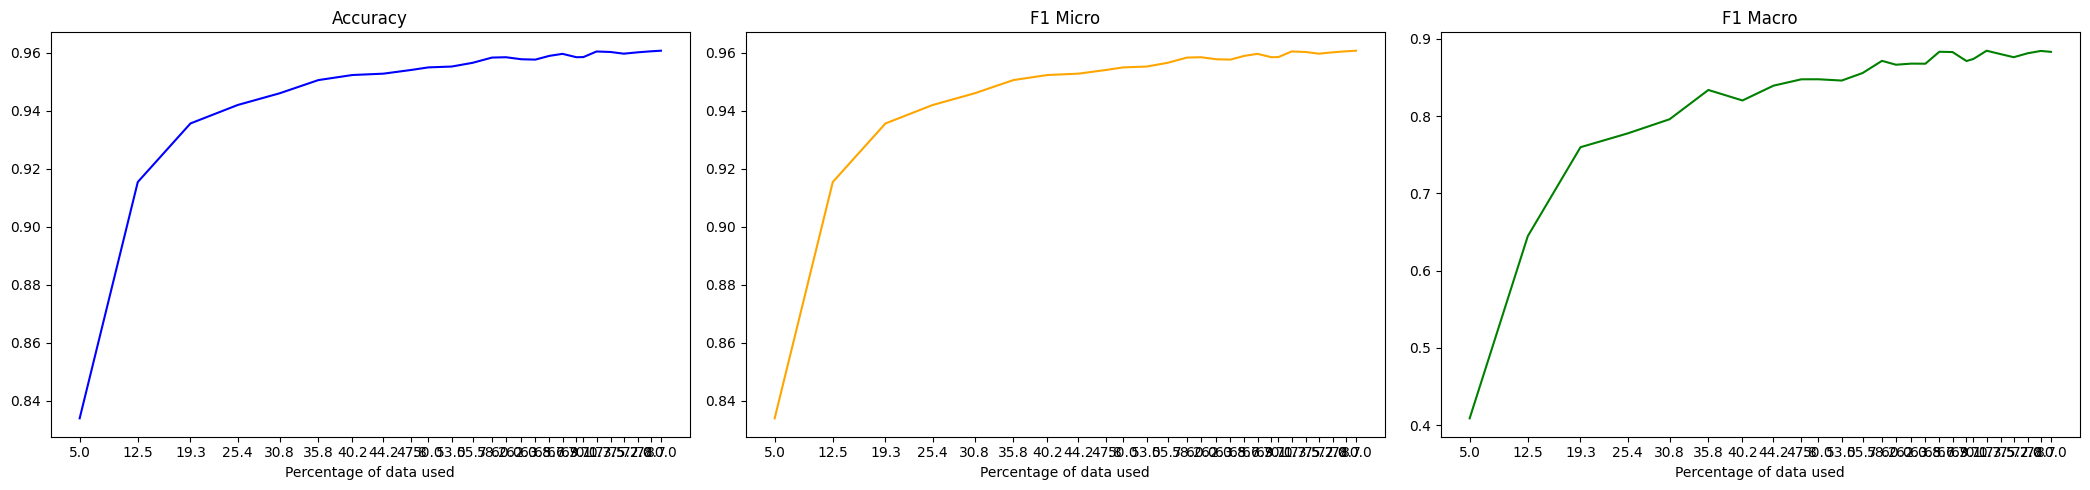

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6848, Accuracy: 0.7875, F1 Micro: 0.8802, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5272, Accuracy: 0.801, F1 Micro: 0.8894, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4543, Accuracy: 0.801, F1 Micro: 0.8894, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4354, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3965, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4036, Accuracy: 0.804, F1 Micro: 0.8903, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4002, Accuracy: 0.8062, F1 Micro: 0.8906, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3687, Accuracy: 0.8104, F1 Micro: 0.8924, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6116, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Epoch 2/10, Train Loss: 0.4879, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 3/10, Train Loss: 0.4436, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 4/10, Train Loss: 0.4304, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.396, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4046, Accuracy: 0.8043, F1 Micro: 0.8904, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4022, Accuracy: 0.8062, F1 Micro: 0.8908, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3655, Accuracy: 0.8111, F1 Micro: 0.8931, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3526, Accuracy: 0.8257, F1 Micro: 0.8997, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5826, Accuracy: 0.8005, F1 Micro: 0.8892, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4818, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4439, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 4/10, Train Loss: 0.428, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3936, Accuracy: 0.8019, F1 Micro: 0.8898, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4034, Accuracy: 0.8064, F1 Micro: 0.8908, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3926, Accuracy: 0.8106, F1 Micro: 0.8926, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3603, Accuracy: 0.817, F1 Micro: 0.8961, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3387, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5897, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.885
Epoch 2/10, Train Loss: 0.4501, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4473, Accuracy: 0.8043, F1 Micro: 0.8911, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4056, Accuracy: 0.8403, F1 Micro: 0.9081, F1 Macro: 0.9014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3768, Accuracy: 0.871, F1 Micro: 0.9241, F1 Macro: 0.9183
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3235, Accuracy: 0.8856, F1 Micro: 0.9322, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2771, Accuracy: 0.9019, F1 Micro: 0.9414, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2363, Accuracy: 0.9116, F1 Micro: 0.9469, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2113, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5479, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 2/10, Train Loss: 0.4452, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4487, Accuracy: 0.8095, F1 Micro: 0.8933, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4139, Accuracy: 0.8325, F1 Micro: 0.9039, F1 Macro: 0.8974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3855, Accuracy: 0.8552, F1 Micro: 0.9158, F1 Macro: 0.9108
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3367, Accuracy: 0.8793, F1 Micro: 0.9288, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2837, Accuracy: 0.8951, F1 Micro: 0.9376, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2405, Accuracy: 0.9076, F1 Micro: 0.9445, F1 Macro: 0.9413
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2144, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.531, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 2/10, Train Loss: 0.445, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4479, Accuracy: 0.8064, F1 Micro: 0.8921, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3996, Accuracy: 0.8422, F1 Micro: 0.9089, F1 Macro: 0.9023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3676, Accuracy: 0.8722, F1 Micro: 0.9247, F1 Macro: 0.9192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3144, Accuracy: 0.8832, F1 Micro: 0.9307, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2659, Accuracy: 0.905, F1 Micro: 0.9432, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2255, Accuracy: 0.916, F1 Micro: 0.9493, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2035, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5516, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4381, Accuracy: 0.8031, F1 Micro: 0.8905, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.408, Accuracy: 0.8441, F1 Micro: 0.9099, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3438, Accuracy: 0.8781, F1 Micro: 0.928, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.283, Accuracy: 0.905, F1 Micro: 0.9429, F1 Macro: 0.9385
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2426, Accuracy: 0.9153, F1 Micro: 0.949, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2004, Accuracy: 0.9266, F1 Micro: 0.9555, F1 Macro: 0.9525
Epoch 8/10, Train Loss: 0.1839, Accuracy: 0.9234, F1 Micro: 0.954, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1509, Accuracy: 0.935

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5129, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4397, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4165, Accuracy: 0.8255, F1 Micro: 0.9012, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3538, Accuracy: 0.8738, F1 Micro: 0.9258, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2899, Accuracy: 0.8991, F1 Micro: 0.9399, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2469, Accuracy: 0.917, F1 Micro: 0.9498, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2038, Accuracy: 0.9191, F1 Micro: 0.9512, F1 Macro: 0.9483
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.183, Accuracy: 0.9285, F1 Micro: 0.9566, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5085, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4433, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.408, Accuracy: 0.8446, F1 Micro: 0.9107, F1 Macro: 0.9045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3417, Accuracy: 0.8814, F1 Micro: 0.93, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.273, Accuracy: 0.9071, F1 Micro: 0.9444, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2325, Accuracy: 0.9203, F1 Micro: 0.9518, F1 Macro: 0.9496
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1933, Accuracy: 0.9231, F1 Micro: 0.9536, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1776, Accuracy: 0.9319, F1 Micro: 0.9587, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5261, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4358, Accuracy: 0.8278, F1 Micro: 0.9017, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.381, Accuracy: 0.8726, F1 Micro: 0.9252, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3124, Accuracy: 0.9056, F1 Micro: 0.9435, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.25, Accuracy: 0.922, F1 Micro: 0.9529, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2137, Accuracy: 0.9318, F1 Micro: 0.9586, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1753, Accuracy: 0.941, F1 Micro: 0.9639, F1 Macro: 0.9612
Epoch 8/10, Train Loss: 0.1555, Accuracy: 0.9365, F1 Micro: 0.9614, F1 Macro: 0.9588
Epoch 9/10, Train Loss: 0.144, Accuracy: 0.9384, F1 Micro: 0.9625, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.503, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.439, Accuracy: 0.8175, F1 Micro: 0.8968, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3867, Accuracy: 0.8687, F1 Micro: 0.9234, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.319, Accuracy: 0.8974, F1 Micro: 0.939, F1 Macro: 0.9359
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2543, Accuracy: 0.9194, F1 Micro: 0.9513, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2166, Accuracy: 0.9274, F1 Micro: 0.956, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1804, Accuracy: 0.9342, F1 Micro: 0.9599, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1625, Accuracy: 0.9351, F1 Micro: 0.9606, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4918, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.434, Accuracy: 0.8144, F1 Micro: 0.8961, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.371, Accuracy: 0.8767, F1 Micro: 0.9276, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2994, Accuracy: 0.9097, F1 Micro: 0.9461, F1 Macro: 0.944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2378, Accuracy: 0.9267, F1 Micro: 0.9556, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2037, Accuracy: 0.9332, F1 Micro: 0.9593, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1693, Accuracy: 0.9405, F1 Micro: 0.9636, F1 Macro: 0.9611
Epoch 8/10, Train Loss: 0.1505, Accuracy: 0.9373, F1 Micro: 0.9619, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1381, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5227, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.423, Accuracy: 0.8415, F1 Micro: 0.9088, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3358, Accuracy: 0.9, F1 Micro: 0.9402, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2706, Accuracy: 0.9193, F1 Micro: 0.9513, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2278, Accuracy: 0.9372, F1 Micro: 0.9617, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1901, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9642
Epoch 7/10, Train Loss: 0.1619, Accuracy: 0.9453, F1 Micro: 0.9665, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1388, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1226, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5018, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4252, Accuracy: 0.8262, F1 Micro: 0.9014, F1 Macro: 0.8957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3422, Accuracy: 0.8984, F1 Micro: 0.9393, F1 Macro: 0.9359
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2718, Accuracy: 0.9187, F1 Micro: 0.9509, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2314, Accuracy: 0.9339, F1 Micro: 0.9598, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1923, Accuracy: 0.9389, F1 Micro: 0.9627, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1668, Accuracy: 0.9399, F1 Micro: 0.9634, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1377, Accuracy: 0.9448, F1 Micro: 0.9663, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4929, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.417, Accuracy: 0.855, F1 Micro: 0.9161, F1 Macro: 0.9106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3267, Accuracy: 0.9047, F1 Micro: 0.9433, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2587, Accuracy: 0.9233, F1 Micro: 0.9537, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2208, Accuracy: 0.937, F1 Micro: 0.9616, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1858, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1543, Accuracy: 0.9464, F1 Micro: 0.9672, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1354, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5154, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4116, Accuracy: 0.8722, F1 Micro: 0.924, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3189, Accuracy: 0.9019, F1 Micro: 0.9416, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2618, Accuracy: 0.9361, F1 Micro: 0.961, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2064, Accuracy: 0.9425, F1 Micro: 0.9648, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1714, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1458, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9676
Epoch 8/10, Train Loss: 0.1289, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1197, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4992, Accuracy: 0.8017, F1 Micro: 0.8899, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4191, Accuracy: 0.8635, F1 Micro: 0.9199, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3271, Accuracy: 0.9017, F1 Micro: 0.9413, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.27, Accuracy: 0.9299, F1 Micro: 0.9572, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2105, Accuracy: 0.9403, F1 Micro: 0.9634, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1749, Accuracy: 0.9424, F1 Micro: 0.9647, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1501, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1296, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4928, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4068, Accuracy: 0.8771, F1 Micro: 0.9271, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3109, Accuracy: 0.9137, F1 Micro: 0.9481, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2522, Accuracy: 0.9335, F1 Micro: 0.9595, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.199, Accuracy: 0.9418, F1 Micro: 0.9644, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1686, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.141, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1221, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5101, Accuracy: 0.8057, F1 Micro: 0.8917, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3914, Accuracy: 0.8793, F1 Micro: 0.9291, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2984, Accuracy: 0.9184, F1 Micro: 0.9508, F1 Macro: 0.948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2287, Accuracy: 0.9396, F1 Micro: 0.9632, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.196, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1672, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1368, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1174, Accuracy: 0.9523, F1 Micro: 0.9707, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4945, Accuracy: 0.8062, F1 Micro: 0.8918, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3989, Accuracy: 0.8672, F1 Micro: 0.9231, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3035, Accuracy: 0.916, F1 Micro: 0.9494, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2356, Accuracy: 0.9344, F1 Micro: 0.9601, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2039, Accuracy: 0.9354, F1 Micro: 0.9608, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1697, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.9649
Epoch 7/10, Train Loss: 0.1367, Accuracy: 0.9441, F1 Micro: 0.966, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1201, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1015, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4875, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3861, Accuracy: 0.8724, F1 Micro: 0.9258, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2907, Accuracy: 0.9253, F1 Micro: 0.9548, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2227, Accuracy: 0.9373, F1 Micro: 0.9618, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1914, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1617, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1324, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.115, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4946, Accuracy: 0.8125, F1 Micro: 0.8914, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3837, Accuracy: 0.8905, F1 Micro: 0.9349, F1 Macro: 0.9298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2831, Accuracy: 0.9373, F1 Micro: 0.9617, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2163, Accuracy: 0.9411, F1 Micro: 0.964, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1833, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9692
Epoch 6/10, Train Loss: 0.1515, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9714
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.9573, F1 Micro: 0.9735, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0948, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4794, Accuracy: 0.8083, F1 Micro: 0.8895, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3916, Accuracy: 0.8875, F1 Micro: 0.933, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2878, Accuracy: 0.928, F1 Micro: 0.956, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2241, Accuracy: 0.9408, F1 Micro: 0.9637, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1852, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9663
Epoch 6/10, Train Loss: 0.1553, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1276, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9705
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0968, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.476, Accuracy: 0.8163, F1 Micro: 0.8954, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3704, Accuracy: 0.8931, F1 Micro: 0.9365, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2709, Accuracy: 0.9351, F1 Micro: 0.9604, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2122, Accuracy: 0.9427, F1 Micro: 0.9649, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1761, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9677
Epoch 6/10, Train Loss: 0.1481, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1195, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9709
Epoch 8/10, Train Loss: 0.1079, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9585, F1 Micro: 0.9742, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4982, Accuracy: 0.8085, F1 Micro: 0.8929, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3651, Accuracy: 0.8979, F1 Micro: 0.9391, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2648, Accuracy: 0.9321, F1 Micro: 0.9585, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2067, Accuracy: 0.9446, F1 Micro: 0.9662, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1686, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9686
Epoch 6/10, Train Loss: 0.1487, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.126, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1059, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0906, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4848, Accuracy: 0.8127, F1 Micro: 0.8944, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.377, Accuracy: 0.8944, F1 Micro: 0.9372, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2715, Accuracy: 0.9255, F1 Micro: 0.9548, F1 Macro: 0.9525
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.212, Accuracy: 0.9451, F1 Micro: 0.9665, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1537, Accuracy: 0.9509, F1 Micro: 0.9699, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1272, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1057, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4754, Accuracy: 0.8188, F1 Micro: 0.8978, F1 Macro: 0.8926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3476, Accuracy: 0.9089, F1 Micro: 0.9455, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2513, Accuracy: 0.9312, F1 Micro: 0.9582, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1993, Accuracy: 0.9443, F1 Micro: 0.966, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1628, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9674
Epoch 6/10, Train Loss: 0.1456, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1221, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1026, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0865, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4909, Accuracy: 0.8186, F1 Micro: 0.8972, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3641, Accuracy: 0.9016, F1 Micro: 0.9414, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2501, Accuracy: 0.9425, F1 Micro: 0.9647, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2011, Accuracy: 0.9422, F1 Micro: 0.9648, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1634, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9725
Epoch 8/10, Train Loss: 0.1052, Accuracy: 0.958, F1 Micro: 0.9739, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0869, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4821, Accuracy: 0.8132, F1 Micro: 0.8939, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3785, Accuracy: 0.9007, F1 Micro: 0.9408, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2605, Accuracy: 0.933, F1 Micro: 0.959, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2107, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1049, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4784, Accuracy: 0.8196, F1 Micro: 0.8983, F1 Macro: 0.893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.361, Accuracy: 0.9108, F1 Micro: 0.9465, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2469, Accuracy: 0.9377, F1 Micro: 0.9619, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9413, F1 Micro: 0.9643, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1379, Accuracy: 0.9524, F1 Micro: 0.9707, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.959, F1 Micro: 0.9745, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4975, Accuracy: 0.8219, F1 Micro: 0.8982, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3578, Accuracy: 0.9057, F1 Micro: 0.9435, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2469, Accuracy: 0.9361, F1 Micro: 0.9611, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9536, F1 Micro: 0.9713, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.0816, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4857, Accuracy: 0.8193, F1 Micro: 0.8963, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3661, Accuracy: 0.9024, F1 Micro: 0.9418, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.253, Accuracy: 0.9276, F1 Micro: 0.9561, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9424, F1 Micro: 0.9649, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1634, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.953, F1 Micro: 0.9709, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0996, Accuracy: 0.9611, F1 Micro: 0.9758, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0848, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4763, Accuracy: 0.8318, F1 Micro: 0.9033, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3436, Accuracy: 0.9149, F1 Micro: 0.949, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2388, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.9422, F1 Micro: 0.9648, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.955, F1 Micro: 0.9721, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9722
Epoch 9/10, Train Loss: 0.0829, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4804, Accuracy: 0.8193, F1 Micro: 0.8984, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3417, Accuracy: 0.9167, F1 Micro: 0.9496, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2366, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1556, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0799, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4727, Accuracy: 0.8116, F1 Micro: 0.8942, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3589, Accuracy: 0.9083, F1 Micro: 0.9447, F1 Macro: 0.9416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2504, Accuracy: 0.9406, F1 Micro: 0.9636, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1938, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9563, F1 Micro: 0.9731, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0814, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4674, Accuracy: 0.8168, F1 Micro: 0.8972, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3393, Accuracy: 0.9179, F1 Micro: 0.9504, F1 Macro: 0.9483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.9451, F1 Micro: 0.9663, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9467, F1 Micro: 0.9673, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9498, F1 Micro: 0.9691, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9566, F1 Micro: 0.9731, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.973
Epoch 9/10, Train Loss: 0.0785, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4857, Accuracy: 0.8255, F1 Micro: 0.9016, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3349, Accuracy: 0.9137, F1 Micro: 0.9481, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2318, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.973
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4784, Accuracy: 0.822, F1 Micro: 0.8994, F1 Macro: 0.8941
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3418, Accuracy: 0.9075, F1 Micro: 0.9448, F1 Macro: 0.9423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.9403, F1 Micro: 0.9635, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1547, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4704, Accuracy: 0.837, F1 Micro: 0.9072, F1 Macro: 0.9026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.326, Accuracy: 0.9179, F1 Micro: 0.9506, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9486, F1 Micro: 0.9684, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.973
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4809, Accuracy: 0.837, F1 Micro: 0.9068, F1 Macro: 0.9014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.323, Accuracy: 0.9224, F1 Micro: 0.9528, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9507, F1 Micro: 0.9698, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4733, Accuracy: 0.825, F1 Micro: 0.9004, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3352, Accuracy: 0.917, F1 Micro: 0.9496, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2334, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4634, Accuracy: 0.8528, F1 Micro: 0.9148, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3143, Accuracy: 0.9264, F1 Micro: 0.9554, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0729, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4897, Accuracy: 0.834, F1 Micro: 0.9052, F1 Macro: 0.8988
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3212, Accuracy: 0.922, F1 Micro: 0.9529, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.9477, F1 Micro: 0.9678, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9732
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9618, F1 Micro: 0.9762, F1 Macro: 0.974
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4816, Accuracy: 0.8208, F1 Micro: 0.8989, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3319, Accuracy: 0.9193, F1 Micro: 0.9513, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2283, Accuracy: 0.9415, F1 Micro: 0.9642, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1897, Accuracy: 0.9484, F1 Micro: 0.9685, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.471, Accuracy: 0.8536, F1 Micro: 0.9154, F1 Macro: 0.9098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3101, Accuracy: 0.9253, F1 Micro: 0.9549, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2136, Accuracy: 0.9491, F1 Micro: 0.9687, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9722
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0734, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4866, Accuracy: 0.845, F1 Micro: 0.9108, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3185, Accuracy: 0.9266, F1 Micro: 0.9556, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2218, Accuracy: 0.9436, F1 Micro: 0.9656, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9718
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4784, Accuracy: 0.8257, F1 Micro: 0.9014, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3295, Accuracy: 0.9253, F1 Micro: 0.9547, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2323, Accuracy: 0.9382, F1 Micro: 0.9624, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4707, Accuracy: 0.8616, F1 Micro: 0.9197, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3113, Accuracy: 0.9299, F1 Micro: 0.9575, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9422, F1 Micro: 0.9648, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0736, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4766, Accuracy: 0.8458, F1 Micro: 0.9117, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3088, Accuracy: 0.9306, F1 Micro: 0.9577, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9611, F1 Micro: 0.9758, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4684, Accuracy: 0.8464, F1 Micro: 0.9112, F1 Macro: 0.9045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3152, Accuracy: 0.9247, F1 Micro: 0.9539, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.9391, F1 Micro: 0.9628, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4622, Accuracy: 0.8599, F1 Micro: 0.919, F1 Macro: 0.9143
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2968, Accuracy: 0.933, F1 Micro: 0.9591, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9625


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 10/10, Train Loss: 0.0599, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.9749

Model 3 of aspect detection, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9753
              precision    recall  f1-score   support

          ac       0.99      0.99      0.99       462
   air_panas    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4753, Accuracy: 0.8696, F1 Micro: 0.9239, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2944, Accuracy: 0.9332, F1 Micro: 0.9594, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9618, F1 Micro: 0.9762, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9606, F1 Micro: 0.9757, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0662, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4718, Accuracy: 0.8488, F1 Micro: 0.9132, F1 Macro: 0.9083
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3023, Accuracy: 0.9285, F1 Micro: 0.9566, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.9451, F1 Micro: 0.9664, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9731
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4631, Accuracy: 0.8774, F1 Micro: 0.9278, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2829, Accuracy: 0.9328, F1 Micro: 0.9592, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9517, F1 Micro: 0.9704, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9618, F1 Micro: 0.9762, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0635, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.8618, F1 Micro: 0.9189, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2914, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9726
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.466, Accuracy: 0.8446, F1 Micro: 0.9093, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3064, Accuracy: 0.9299, F1 Micro: 0.9573, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2174, Accuracy: 0.9413, F1 Micro: 0.9641, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9727
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.9609, F1 Micro: 0.9757, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4575, Accuracy: 0.8658, F1 Micro: 0.9213, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2894, Accuracy: 0.9323, F1 Micro: 0.9589, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.9467, F1 Micro: 0.9673, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9625, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4615, Accuracy: 0.8726, F1 Micro: 0.9249, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2932, Accuracy: 0.9271, F1 Micro: 0.9558, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0687, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4605, Accuracy: 0.8472, F1 Micro: 0.9115, F1 Macro: 0.9053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.311, Accuracy: 0.926, F1 Micro: 0.9552, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9424, F1 Micro: 0.9648, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9528, F1 Micro: 0.9708, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9559, F1 Micro: 0.9727, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4468, Accuracy: 0.879, F1 Micro: 0.9282, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2864, Accuracy: 0.9321, F1 Micro: 0.9587, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9523, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4659, Accuracy: 0.8679, F1 Micro: 0.9224, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2871, Accuracy: 0.9335, F1 Micro: 0.9595, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4599, Accuracy: 0.8569, F1 Micro: 0.9169, F1 Macro: 0.912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2926, Accuracy: 0.9302, F1 Micro: 0.9577, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9418, F1 Micro: 0.9644, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.951, F1 Micro: 0.97, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9742
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4473, Accuracy: 0.8792, F1 Micro: 0.9282, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2752, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0897, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.461, Accuracy: 0.8734, F1 Micro: 0.9256, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2911, Accuracy: 0.9347, F1 Micro: 0.9603, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9507, F1 Micro: 0.9698, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.457, Accuracy: 0.8667, F1 Micro: 0.9222, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2939, Accuracy: 0.9319, F1 Micro: 0.9586, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0629, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.449, Accuracy: 0.8799, F1 Micro: 0.9288, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2837, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.95, F1 Micro: 0.9694, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0745, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4634, Accuracy: 0.8818, F1 Micro: 0.9302, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2787, Accuracy: 0.9328, F1 Micro: 0.9592, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1923, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9695
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9632, F1 Micro: 0.9772, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4559, Accuracy: 0.8724, F1 Micro: 0.9254, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2818, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9462, F1 Micro: 0.9671, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9653, F1 Micro: 0.9784, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4418, Accuracy: 0.8865, F1 Micro: 0.9328, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.265, Accuracy: 0.9328, F1 Micro: 0.9592, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9688
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4563, Accuracy: 0.8769, F1 Micro: 0.9278, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.9448, F1 Micro: 0.9662, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9601, F1 Micro: 0.9754, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4526, Accuracy: 0.8625, F1 Micro: 0.9202, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2832, Accuracy: 0.9351, F1 Micro: 0.9604, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9595, F1 Micro: 0.9751, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.444, Accuracy: 0.8837, F1 Micro: 0.9314, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2667, Accuracy: 0.9389, F1 Micro: 0.9626, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4469, Accuracy: 0.8828, F1 Micro: 0.9307, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4412, Accuracy: 0.8816, F1 Micro: 0.93, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2764, Accuracy: 0.9299, F1 Micro: 0.9574, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9502, F1 Micro: 0.9695, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9637, F1 Micro: 0.9776, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4303, Accuracy: 0.8878, F1 Micro: 0.9337, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.9372, F1 Micro: 0.9617, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.178, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9642, F1 Micro: 0.9779, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.8849, F1 Micro: 0.9322, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.9415, F1 Micro: 0.9643, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4468, Accuracy: 0.8738, F1 Micro: 0.9264, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2689, Accuracy: 0.9337, F1 Micro: 0.9597, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0605, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4347, Accuracy: 0.8828, F1 Micro: 0.9312, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.9391, F1 Micro: 0.9628, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro:

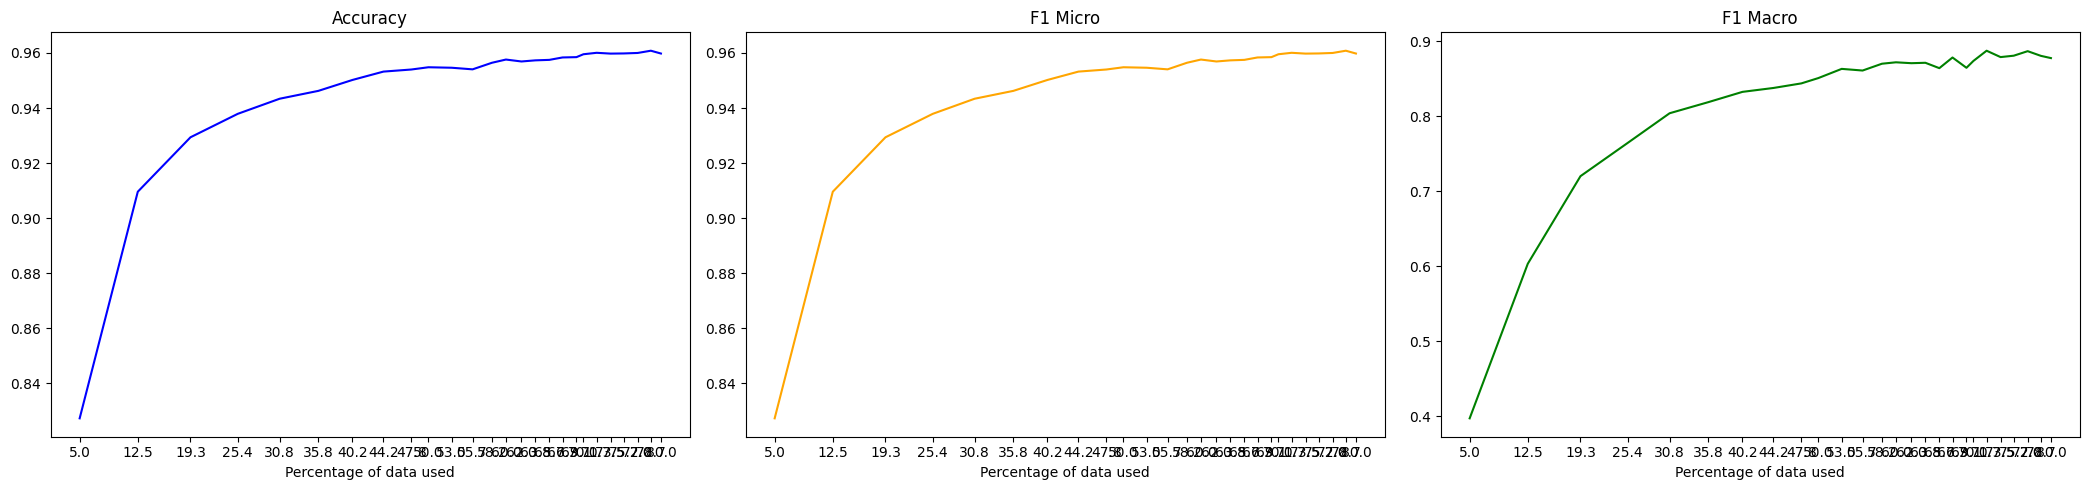

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 61, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6195, Accuracy: 0.801, F1 Micro: 0.8885, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4969, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4457, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4279, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.3931, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4067, Accuracy: 0.8049, F1 Micro: 0.8903, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3999, Accuracy: 0.8069, F1 Micro: 0.8912, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3671, Accuracy: 0.8168, F1 Micro: 0.8956, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3514, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6115, Accuracy: 0.8017, F1 Micro: 0.8893, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4875, Accuracy: 0.8064, F1 Micro: 0.8912, F1 Macro: 0.8845
Epoch 3/10, Train Loss: 0.4466, Accuracy: 0.8035, F1 Micro: 0.8905, F1 Macro: 0.8856
Epoch 4/10, Train Loss: 0.429, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.39, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3952, Accuracy: 0.8146, F1 Micro: 0.8953, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3895, Accuracy: 0.8193, F1 Micro: 0.8967, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3546, Accuracy: 0.8286, F1 Micro: 0.9016, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3391, Accuracy: 0.8385, F1 Micro: 0.906, F1 Macro: 0.8967
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.609, Accuracy: 0.797, F1 Micro: 0.886, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4815, Accuracy: 0.8005, F1 Micro: 0.8892, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4403, Accuracy: 0.8007, F1 Micro: 0.8893, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4196, Accuracy: 0.8017, F1 Micro: 0.8898, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.3856, Accuracy: 0.8023, F1 Micro: 0.8896, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.39, Accuracy: 0.8104, F1 Micro: 0.8923, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3765, Accuracy: 0.8207, F1 Micro: 0.8973, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3393, Accuracy: 0.83, F1 Micro: 0.9021, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3207, Accuracy: 0.84

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5552, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4508, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4366, Accuracy: 0.8102, F1 Micro: 0.8938, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4006, Accuracy: 0.8405, F1 Micro: 0.9081, F1 Macro: 0.9015
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3734, Accuracy: 0.8693, F1 Micro: 0.9227, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3266, Accuracy: 0.8887, F1 Micro: 0.9337, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2788, Accuracy: 0.8995, F1 Micro: 0.9397, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2517, Accuracy: 0.9049, F1 Micro: 0.9429, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5525, Accuracy: 0.8071, F1 Micro: 0.8917, F1 Macro: 0.8854
Epoch 2/10, Train Loss: 0.45, Accuracy: 0.8031, F1 Micro: 0.8906, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4293, Accuracy: 0.8168, F1 Micro: 0.8966, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3934, Accuracy: 0.8484, F1 Micro: 0.9128, F1 Macro: 0.908
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3567, Accuracy: 0.8724, F1 Micro: 0.9248, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3168, Accuracy: 0.8927, F1 Micro: 0.9359, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2677, Accuracy: 0.9017, F1 Micro: 0.9412, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2437, Accuracy: 0.9146, F1 Micro: 0.9487, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2218, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5453, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4502, Accuracy: 0.805, F1 Micro: 0.8909, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4222, Accuracy: 0.8198, F1 Micro: 0.898, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3772, Accuracy: 0.8568, F1 Micro: 0.9169, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3402, Accuracy: 0.8811, F1 Micro: 0.9289, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2978, Accuracy: 0.8924, F1 Micro: 0.9351, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2567, Accuracy: 0.9047, F1 Micro: 0.9426, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.231, Accuracy: 0.9158, F1 Micro: 0.9492, F1 Macro: 0.9456
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5244, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4434, Accuracy: 0.8135, F1 Micro: 0.8956, F1 Macro: 0.8913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4022, Accuracy: 0.8465, F1 Micro: 0.9112, F1 Macro: 0.9051
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3511, Accuracy: 0.8795, F1 Micro: 0.9287, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2951, Accuracy: 0.8998, F1 Micro: 0.9403, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2404, Accuracy: 0.9208, F1 Micro: 0.952, F1 Macro: 0.9489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2096, Accuracy: 0.9229, F1 Micro: 0.9531, F1 Macro: 0.9495
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1813, Accuracy: 0.9274, F1 Micro: 0.9559, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5214, Accuracy: 0.804, F1 Micro: 0.8909, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4406, Accuracy: 0.8227, F1 Micro: 0.8996, F1 Macro: 0.8938
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3909, Accuracy: 0.8602, F1 Micro: 0.9186, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3396, Accuracy: 0.8845, F1 Micro: 0.9316, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2847, Accuracy: 0.9071, F1 Micro: 0.9443, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2294, Accuracy: 0.9238, F1 Micro: 0.9537, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2055, Accuracy: 0.9276, F1 Micro: 0.9558, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1769, Accuracy: 0.934, F1 Micro: 0.9599, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5143, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4342, Accuracy: 0.8205, F1 Micro: 0.8989, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3773, Accuracy: 0.8687, F1 Micro: 0.9229, F1 Macro: 0.9171
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3241, Accuracy: 0.8931, F1 Micro: 0.9362, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2731, Accuracy: 0.9064, F1 Micro: 0.9439, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2234, Accuracy: 0.9245, F1 Micro: 0.9541, F1 Macro: 0.9509
Epoch 7/10, Train Loss: 0.1996, Accuracy: 0.9233, F1 Micro: 0.9532, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1707, Accuracy: 0.9333, F1 Micro: 0.9594, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1413, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5126, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4344, Accuracy: 0.8215, F1 Micro: 0.8995, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3653, Accuracy: 0.8781, F1 Micro: 0.9282, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2943, Accuracy: 0.9083, F1 Micro: 0.945, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2459, Accuracy: 0.9271, F1 Micro: 0.9556, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.204, Accuracy: 0.9316, F1 Micro: 0.9585, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1827, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1527, Accuracy: 0.9415, F1 Micro: 0.9642, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5101, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4307, Accuracy: 0.8432, F1 Micro: 0.9104, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3525, Accuracy: 0.8892, F1 Micro: 0.9343, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2855, Accuracy: 0.9141, F1 Micro: 0.9481, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2372, Accuracy: 0.9326, F1 Micro: 0.959, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2018, Accuracy: 0.9358, F1 Micro: 0.961, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1812, Accuracy: 0.9417, F1 Micro: 0.9642, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1491, Accuracy: 0.945, F1 Micro: 0.9663, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5042, Accuracy: 0.8028, F1 Micro: 0.8902, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4207, Accuracy: 0.8462, F1 Micro: 0.9114, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3356, Accuracy: 0.8889, F1 Micro: 0.934, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2734, Accuracy: 0.9167, F1 Micro: 0.9498, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2329, Accuracy: 0.9238, F1 Micro: 0.9539, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1988, Accuracy: 0.9378, F1 Micro: 0.962, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1799, Accuracy: 0.942, F1 Micro: 0.9645, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1505, Accuracy: 0.9431, F1 Micro: 0.9651, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5151, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4243, Accuracy: 0.8391, F1 Micro: 0.9074, F1 Macro: 0.9023
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.346, Accuracy: 0.8915, F1 Micro: 0.9356, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2692, Accuracy: 0.9189, F1 Micro: 0.9511, F1 Macro: 0.948
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2198, Accuracy: 0.9325, F1 Micro: 0.9588, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1873, Accuracy: 0.9391, F1 Micro: 0.9628, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1614, Accuracy: 0.946, F1 Micro: 0.9668, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.138, Accuracy: 0.9505, F1 Micro: 0.9695, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5128, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4164, Accuracy: 0.8589, F1 Micro: 0.9179, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3294, Accuracy: 0.9062, F1 Micro: 0.9438, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2569, Accuracy: 0.926, F1 Micro: 0.9553, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2108, Accuracy: 0.9385, F1 Micro: 0.9625, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1818, Accuracy: 0.942, F1 Micro: 0.9645, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1557, Accuracy: 0.9491, F1 Micro: 0.9686, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1372, Accuracy: 0.9512, F1 Micro: 0.9699, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5107, Accuracy: 0.8061, F1 Micro: 0.8916, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4033, Accuracy: 0.8689, F1 Micro: 0.9228, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3186, Accuracy: 0.905, F1 Micro: 0.943, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2508, Accuracy: 0.9247, F1 Micro: 0.9544, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2083, Accuracy: 0.9358, F1 Micro: 0.9609, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1811, Accuracy: 0.9434, F1 Micro: 0.9654, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1545, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1363, Accuracy: 0.9514, F1 Micro: 0.97, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5064, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4025, Accuracy: 0.8693, F1 Micro: 0.9224, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3103, Accuracy: 0.9135, F1 Micro: 0.9477, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2491, Accuracy: 0.9316, F1 Micro: 0.9584, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.197, Accuracy: 0.9389, F1 Micro: 0.9627, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1686, Accuracy: 0.9439, F1 Micro: 0.9658, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.142, Accuracy: 0.9514, F1 Micro: 0.97, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1219, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5075, Accuracy: 0.8052, F1 Micro: 0.8915, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3983, Accuracy: 0.8769, F1 Micro: 0.9271, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3031, Accuracy: 0.916, F1 Micro: 0.9492, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2449, Accuracy: 0.9389, F1 Micro: 0.9627, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.196, Accuracy: 0.9443, F1 Micro: 0.9658, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1646, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1406, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1176, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4986, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3794, Accuracy: 0.8854, F1 Micro: 0.9319, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2868, Accuracy: 0.92, F1 Micro: 0.9515, F1 Macro: 0.9479
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2352, Accuracy: 0.9377, F1 Micro: 0.9619, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1891, Accuracy: 0.9441, F1 Micro: 0.9657, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1626, Accuracy: 0.9453, F1 Micro: 0.9665, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1433, Accuracy: 0.9535, F1 Micro: 0.9712, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1184, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4899, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3979, Accuracy: 0.8771, F1 Micro: 0.9279, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.304, Accuracy: 0.921, F1 Micro: 0.9523, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2255, Accuracy: 0.9337, F1 Micro: 0.9596, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1934, Accuracy: 0.9391, F1 Micro: 0.9629, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1585, Accuracy: 0.947, F1 Micro: 0.9676, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1386, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1168, Accuracy: 0.9549, F1 Micro: 0.972, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4891, Accuracy: 0.803, F1 Micro: 0.8905, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.389, Accuracy: 0.8873, F1 Micro: 0.9336, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2972, Accuracy: 0.9243, F1 Micro: 0.9542, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2181, Accuracy: 0.9373, F1 Micro: 0.9617, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9429, F1 Micro: 0.9651, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1384, Accuracy: 0.9564, F1 Micro: 0.973, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1162, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4829, Accuracy: 0.8019, F1 Micro: 0.89, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3743, Accuracy: 0.8825, F1 Micro: 0.931, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2899, Accuracy: 0.9226, F1 Micro: 0.9532, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2161, Accuracy: 0.9373, F1 Micro: 0.9618, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1867, Accuracy: 0.942, F1 Micro: 0.9646, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1549, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1373, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.116, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4823, Accuracy: 0.8122, F1 Micro: 0.8946, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3724, Accuracy: 0.8941, F1 Micro: 0.9369, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2708, Accuracy: 0.9306, F1 Micro: 0.9576, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.9406, F1 Micro: 0.9637, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1692, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1494, Accuracy: 0.9524, F1 Micro: 0.9706, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1258, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9714
Epoch 8/10, Train Loss: 0.102, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9712
Epoch 9/10, Train Loss: 0.0873, Accuracy: 0.9569, F1 Micro: 0.9732, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.476, Accuracy: 0.826, F1 Micro: 0.9014, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3562, Accuracy: 0.9036, F1 Micro: 0.9424, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2567, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.9569, F1 Micro: 0.9733, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1208, Accuracy: 0.9611, F1 Micro: 0.9758, F1 Macro: 0.9731
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4709, Accuracy: 0.828, F1 Micro: 0.9022, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3483, Accuracy: 0.9014, F1 Micro: 0.9409, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.9332, F1 Micro: 0.9592, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2035, Accuracy: 0.9434, F1 Micro: 0.9653, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1468, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1235, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0871, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4854, Accuracy: 0.8181, F1 Micro: 0.8978, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3683, Accuracy: 0.9019, F1 Micro: 0.9412, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2611, Accuracy: 0.933, F1 Micro: 0.9592, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2112, Accuracy: 0.9443, F1 Micro: 0.9658, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.171, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1429, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.973
Epoch 9/10, Train Loss: 0.0885, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4871, Accuracy: 0.8278, F1 Micro: 0.9014, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3579, Accuracy: 0.9078, F1 Micro: 0.9446, F1 Macro: 0.9404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2584, Accuracy: 0.9361, F1 Micro: 0.961, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2053, Accuracy: 0.945, F1 Micro: 0.9662, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4768, Accuracy: 0.8257, F1 Micro: 0.9016, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3431, Accuracy: 0.9097, F1 Micro: 0.9457, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2496, Accuracy: 0.9377, F1 Micro: 0.9619, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2007, Accuracy: 0.947, F1 Micro: 0.9674, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1158, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0848, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4736, Accuracy: 0.8335, F1 Micro: 0.9051, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.36, Accuracy: 0.9017, F1 Micro: 0.9412, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2546, Accuracy: 0.9345, F1 Micro: 0.9602, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.954, F1 Micro: 0.9714, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0871, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4712, Accuracy: 0.8391, F1 Micro: 0.9079, F1 Macro: 0.903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.348, Accuracy: 0.9158, F1 Micro: 0.9491, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2455, Accuracy: 0.938, F1 Micro: 0.9623, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.949, F1 Micro: 0.9685, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9552, F1 Micro: 0.9722, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4635, Accuracy: 0.8497, F1 Micro: 0.9134, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3335, Accuracy: 0.9099, F1 Micro: 0.9457, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2378, Accuracy: 0.9384, F1 Micro: 0.9625, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9536, F1 Micro: 0.9713, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0834, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4748, Accuracy: 0.8325, F1 Micro: 0.9045, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3495, Accuracy: 0.9123, F1 Micro: 0.9471, F1 Macro: 0.9426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.234, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9444, F1 Micro: 0.9661, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9536, F1 Micro: 0.9716, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.958, F1 Micro: 0.9739, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0772, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4706, Accuracy: 0.8441, F1 Micro: 0.9106, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3363, Accuracy: 0.9248, F1 Micro: 0.9544, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.228, Accuracy: 0.942, F1 Micro: 0.9646, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1552, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4677, Accuracy: 0.8493, F1 Micro: 0.9134, F1 Macro: 0.9083
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3322, Accuracy: 0.9187, F1 Micro: 0.9505, F1 Macro: 0.9456
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2264, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9455, F1 Micro: 0.9667, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1247, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.077, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4796, Accuracy: 0.8319, F1 Micro: 0.9045, F1 Macro: 0.9003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3347, Accuracy: 0.9167, F1 Micro: 0.95, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.9373, F1 Micro: 0.9619, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9542, F1 Micro: 0.9717, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9627, F1 Micro: 0.9767, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0796, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4733, Accuracy: 0.847, F1 Micro: 0.9123, F1 Macro: 0.908
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3195, Accuracy: 0.9273, F1 Micro: 0.9559, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4699, Accuracy: 0.8613, F1 Micro: 0.9186, F1 Macro: 0.9122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3115, Accuracy: 0.9224, F1 Micro: 0.9531, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2299, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0789, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4745, Accuracy: 0.8366, F1 Micro: 0.9068, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3363, Accuracy: 0.9139, F1 Micro: 0.9481, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2378, Accuracy: 0.945, F1 Micro: 0.9662, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.962, F1 Micro: 0.9763, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.472, Accuracy: 0.8457, F1 Micro: 0.9115, F1 Macro: 0.9068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3246, Accuracy: 0.9259, F1 Micro: 0.955, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2329, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4643, Accuracy: 0.8604, F1 Micro: 0.9191, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3132, Accuracy: 0.9247, F1 Micro: 0.9543, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2289, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9495, F1 Micro: 0.9689, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4701, Accuracy: 0.8394, F1 Micro: 0.9078, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3308, Accuracy: 0.9217, F1 Micro: 0.9525, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2284, Accuracy: 0.9451, F1 Micro: 0.9663, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9521, F1 Micro: 0.9704, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9737
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4637, Accuracy: 0.8635, F1 Micro: 0.9205, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3127, Accuracy: 0.9335, F1 Micro: 0.9594, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4558, Accuracy: 0.8698, F1 Micro: 0.9238, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3056, Accuracy: 0.9306, F1 Micro: 0.9575, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9469, F1 Micro: 0.9673, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4771, Accuracy: 0.853, F1 Micro: 0.9151, F1 Macro: 0.91
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3187, Accuracy: 0.9257, F1 Micro: 0.9548, F1 Macro: 0.9516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9644, F1 Micro: 0.978, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9731
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4698, Accuracy: 0.8731, F1 Micro: 0.9256, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3039, Accuracy: 0.9309, F1 Micro: 0.9581, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.462, Accuracy: 0.8757, F1 Micro: 0.9268, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2962, Accuracy: 0.9295, F1 Micro: 0.9571, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.47, Accuracy: 0.8547, F1 Micro: 0.9154, F1 Macro: 0.9096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3116, Accuracy: 0.928, F1 Micro: 0.956, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.9472, F1 Micro: 0.9674, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9571, F1 Micro: 0.9734, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4641, Accuracy: 0.8719, F1 Micro: 0.9245, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3003, Accuracy: 0.9335, F1 Micro: 0.9593, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.962, F1 Micro: 0.9763, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4569, Accuracy: 0.8785, F1 Micro: 0.9274, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2909, Accuracy: 0.9349, F1 Micro: 0.96, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.21, Accuracy: 0.9503, F1 Micro: 0.9693, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4594, Accuracy: 0.8542, F1 Micro: 0.9159, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3055, Accuracy: 0.9295, F1 Micro: 0.9573, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9505, F1 Micro: 0.9695, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.07, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.456, Accuracy: 0.8674, F1 Micro: 0.9228, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2954, Accuracy: 0.9307, F1 Micro: 0.9581, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9754
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9641, F1 Micro: 0.9778, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9649, F1 Micro: 0.9783, F1 Macro: 0.9763
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4485, Accuracy: 0.8696, F1 Micro: 0.9241, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2882, Accuracy: 0.933, F1 Micro: 0.9593, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9741
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4715, Accuracy: 0.8479, F1 Micro: 0.9127, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3025, Accuracy: 0.9281, F1 Micro: 0.9565, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9455, F1 Micro: 0.9667, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4668, Accuracy: 0.8646, F1 Micro: 0.9213, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2915, Accuracy: 0.934, F1 Micro: 0.9599, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4588, Accuracy: 0.8719, F1 Micro: 0.925, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.284, Accuracy: 0.9372, F1 Micro: 0.9617, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9738
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0632, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4598, Accuracy: 0.8674, F1 Micro: 0.9219, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2956, Accuracy: 0.9295, F1 Micro: 0.9572, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0648, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4534, Accuracy: 0.8764, F1 Micro: 0.9272, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.285, Accuracy: 0.9326, F1 Micro: 0.959, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.8804, F1 Micro: 0.9289, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.283, Accuracy: 0.9363, F1 Micro: 0.9611, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0638, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4607, Accuracy: 0.8681, F1 Micro: 0.9224, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2962, Accuracy: 0.929, F1 Micro: 0.957, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9493, F1 Micro: 0.969, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9644, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4522, Accuracy: 0.8845, F1 Micro: 0.9316, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2837, Accuracy: 0.9314, F1 Micro: 0.9585, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.95, F1 Micro: 0.9694, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4448, Accuracy: 0.8823, F1 Micro: 0.93, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2773, Accuracy: 0.9351, F1 Micro: 0.9605, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0641, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4562, Accuracy: 0.8722, F1 Micro: 0.9247, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2868, Accuracy: 0.933, F1 Micro: 0.9592, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0897, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4492, Accuracy: 0.8807, F1 Micro: 0.9298, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0616, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4412, Accuracy: 0.8854, F1 Micro: 0.932, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.9406, F1 Micro: 0.9637, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9644, F1 Micro: 0.978, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4473, Accuracy: 0.8717, F1 Micro: 0.9252, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2748, Accuracy: 0.9345, F1 Micro: 0.9601, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9472, F1 Micro: 0.9678, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9744
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9748
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4417, Accuracy: 0.8826, F1 Micro: 0.9309, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9354, F1 Micro: 0.9607, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9472, F1 Micro: 0.9678, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.433, Accuracy: 0.8818, F1 Micro: 0.9307, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2646, Accuracy: 0.9363, F1 Micro: 0.9611, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1946, Accuracy: 0.9467, F1 Micro: 0.9674, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9752
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9649, F1 Micro: 0.9783, F1 Macro: 0.9763
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4496, Accuracy: 0.8767, F1 Micro: 0.9273, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2758, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9448, F1 Micro: 0.9661, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0635, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4447, Accuracy: 0.8872, F1 Micro: 0.9332, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2673, Accuracy: 0.9403, F1 Micro: 0.9637, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.9658, F1 Micro: 0.9787, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.431, Accuracy: 0.8901, F1 Micro: 0.935, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9427, F1 Micro: 0.9649, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0615, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4407, Accuracy: 0.8774, F1 Micro: 0.9275, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2721, Accuracy: 0.9354, F1 Micro: 0.9606, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9649, F1 Micro: 0.9783, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4345, Accuracy: 0.883, F1 Micro: 0.9311, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.9375, F1 Micro: 0.962, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9749
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4257, Accuracy: 0.8865, F1 Micro: 0.9327, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.9399, F1 Micro: 0.9632, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1849, Accuracy: 0.9524, F1 Micro: 0.9707, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0584, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4392, Accuracy: 0.8851, F1 Micro: 0.9317, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.9366, F1 Micro: 0.9614, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9746
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9752
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4341, Accuracy: 0.8953, F1 Micro: 0.9375, F1 Macro: 0.9321
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.941, F1 Micro: 0.9641, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4253, Accuracy: 0.8964, F1 Micro: 0.9378, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.9396, F1 Micro: 0.9632, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0564, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.883, F1 Micro: 0.931, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2629, Accuracy: 0.9319, F1 Micro: 0.9588, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4346, Accuracy: 0.8903, F1 Micro: 0.935, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2541, Accuracy: 0.9354, F1 Micro: 0.9608, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0567, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.425, Accuracy: 0.8938, F1 Micro: 0.9372, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.9337, F1 Micro: 0.9598, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1416, Accuracy: 0.9557, F1 Micro: 0.9726, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9763
Higher F1 achieved, sa

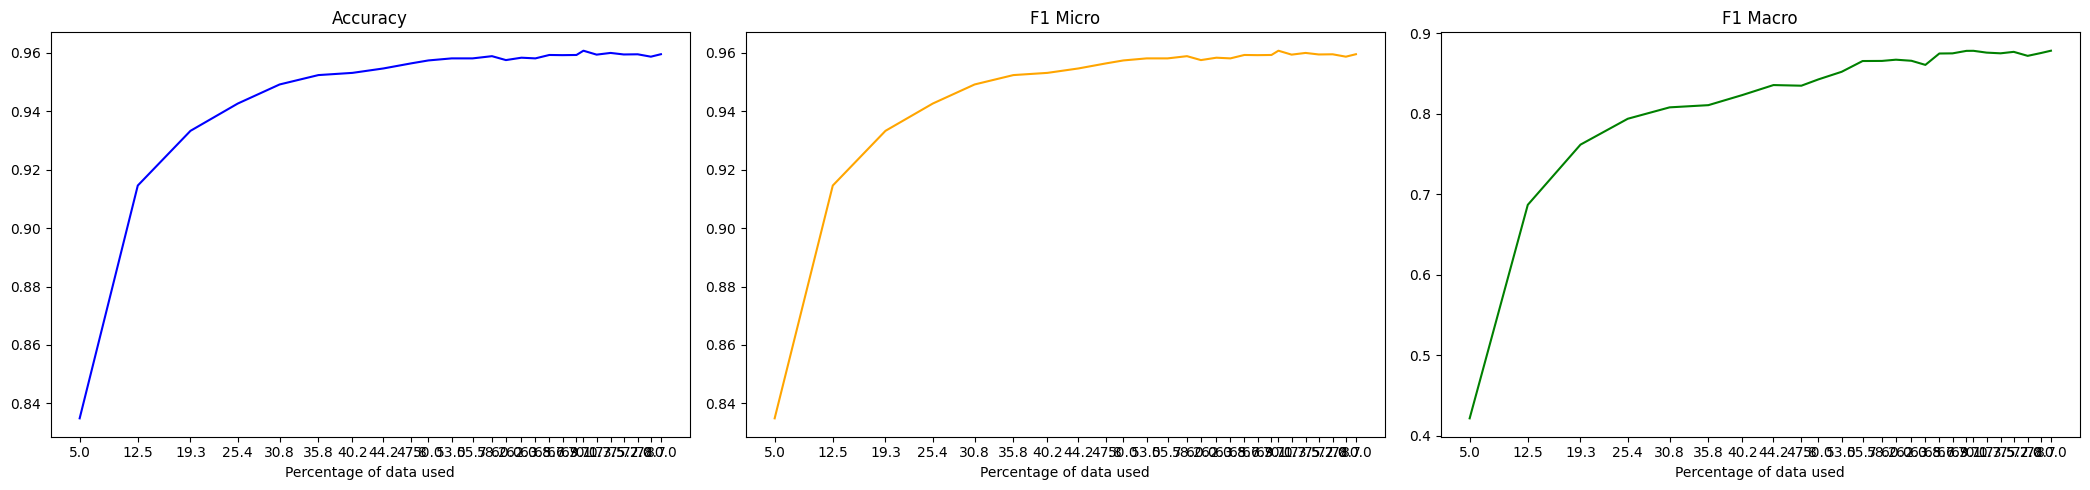

In [25]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5977, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4771, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4402, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4268, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3933, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4013, Accuracy: 0.8031, F1 Micro: 0.8905, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3946, Accuracy: 0.812, F1 Micro: 0.894, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3594, Accuracy: 0.8219, F1 Micro: 0.8985, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6288, Accuracy: 0.8005, F1 Micro: 0.8888, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5061, Accuracy: 0.801, F1 Micro: 0.8892, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4534, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8853
Epoch 4/10, Train Loss: 0.4366, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3986, Accuracy: 0.8021, F1 Micro: 0.89, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4086, Accuracy: 0.8052, F1 Micro: 0.891, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4052, Accuracy: 0.8066, F1 Micro: 0.8918, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.373, Accuracy: 0.8158, F1 Micro: 0.8951, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3537, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6232, Accuracy: 0.7993, F1 Micro: 0.8884, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4862, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4428, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Epoch 4/10, Train Loss: 0.4292, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.3938, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 6/10, Train Loss: 0.4034, Accuracy: 0.8024, F1 Micro: 0.8896, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3977, Accuracy: 0.8083, F1 Micro: 0.8917, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3656, Accuracy: 0.8188, F1 Micro: 0.8958, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3497, Accuracy: 0.8278, F1 Micro: 0.9008, F1 Macro: 0.8916
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4635, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4415, Accuracy: 0.8118, F1 Micro: 0.8944, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4114, Accuracy: 0.8446, F1 Micro: 0.9097, F1 Macro: 0.9017
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3772, Accuracy: 0.8774, F1 Micro: 0.9268, F1 Macro: 0.9199
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3137, Accuracy: 0.8972, F1 Micro: 0.9384, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.268, Accuracy: 0.912, F1 Micro: 0.947, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2342, Accuracy: 0.924, F1 Micro: 0.9539, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5566, Accuracy: 0.8038, F1 Micro: 0.8899, F1 Macro: 0.883
Epoch 2/10, Train Loss: 0.4658, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4472, Accuracy: 0.8083, F1 Micro: 0.892, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4237, Accuracy: 0.834, F1 Micro: 0.9044, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.398, Accuracy: 0.8661, F1 Micro: 0.9209, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3264, Accuracy: 0.8823, F1 Micro: 0.9301, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2929, Accuracy: 0.8922, F1 Micro: 0.9356, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2582, Accuracy: 0.9033, F1 Micro: 0.9417, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2301, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5548, Accuracy: 0.8028, F1 Micro: 0.8896, F1 Macro: 0.8833
Epoch 2/10, Train Loss: 0.4591, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.442, Accuracy: 0.8066, F1 Micro: 0.8914, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4143, Accuracy: 0.8366, F1 Micro: 0.9061, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.383, Accuracy: 0.8781, F1 Micro: 0.9275, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3183, Accuracy: 0.8934, F1 Micro: 0.9363, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2826, Accuracy: 0.9036, F1 Micro: 0.9422, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2509, Accuracy: 0.9092, F1 Micro: 0.945, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2257, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5167, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4453, Accuracy: 0.8094, F1 Micro: 0.8933, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4073, Accuracy: 0.858, F1 Micro: 0.9167, F1 Macro: 0.9091
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3344, Accuracy: 0.8918, F1 Micro: 0.9358, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2833, Accuracy: 0.9177, F1 Micro: 0.9501, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2396, Accuracy: 0.928, F1 Micro: 0.9563, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1914, Accuracy: 0.9319, F1 Micro: 0.9586, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1681, Accuracy: 0.9406, F1 Micro: 0.9636, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5303, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4462, Accuracy: 0.8092, F1 Micro: 0.893, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4142, Accuracy: 0.8481, F1 Micro: 0.9112, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3484, Accuracy: 0.8755, F1 Micro: 0.927, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3034, Accuracy: 0.8976, F1 Micro: 0.9388, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.261, Accuracy: 0.9139, F1 Micro: 0.948, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2058, Accuracy: 0.9269, F1 Micro: 0.9555, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1842, Accuracy: 0.9354, F1 Micro: 0.9605, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5211, Accuracy: 0.8019, F1 Micro: 0.8897, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4389, Accuracy: 0.8111, F1 Micro: 0.8937, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4055, Accuracy: 0.8557, F1 Micro: 0.9158, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3355, Accuracy: 0.8903, F1 Micro: 0.935, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2888, Accuracy: 0.9087, F1 Micro: 0.945, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2495, Accuracy: 0.9194, F1 Micro: 0.9511, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.204, Accuracy: 0.9304, F1 Micro: 0.9576, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.18, Accuracy: 0.9373, F1 Micro: 0.9617, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5056, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4447, Accuracy: 0.8361, F1 Micro: 0.9057, F1 Macro: 0.8982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3668, Accuracy: 0.8865, F1 Micro: 0.9325, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2899, Accuracy: 0.9208, F1 Micro: 0.9519, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2348, Accuracy: 0.9318, F1 Micro: 0.9585, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1953, Accuracy: 0.941, F1 Micro: 0.9639, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1757, Accuracy: 0.945, F1 Micro: 0.9663, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1511, Accuracy: 0.9458, F1 Micro: 0.9667, F1 Macro: 0.9644
Epoch 9/10, Train Loss: 0.1301, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5204, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4545, Accuracy: 0.8212, F1 Micro: 0.8991, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3855, Accuracy: 0.8738, F1 Micro: 0.9257, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3102, Accuracy: 0.9012, F1 Micro: 0.9408, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2572, Accuracy: 0.92, F1 Micro: 0.9517, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2119, Accuracy: 0.9366, F1 Micro: 0.9614, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1925, Accuracy: 0.9413, F1 Micro: 0.964, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1594, Accuracy: 0.9431, F1 Micro: 0.965, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5111, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.446, Accuracy: 0.8389, F1 Micro: 0.9073, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3692, Accuracy: 0.8818, F1 Micro: 0.93, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2962, Accuracy: 0.9078, F1 Micro: 0.9447, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2432, Accuracy: 0.9283, F1 Micro: 0.9563, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2018, Accuracy: 0.9382, F1 Micro: 0.9622, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1825, Accuracy: 0.942, F1 Micro: 0.9644, F1 Macro: 0.9619
Epoch 8/10, Train Loss: 0.1598, Accuracy: 0.9399, F1 Micro: 0.9633, F1 Macro: 0.9609
Epoch 9/10, Train Loss: 0.1351, Accuracy: 0.9415, F1 Micro: 0.9643, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4907, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4108, Accuracy: 0.8599, F1 Micro: 0.9183, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3263, Accuracy: 0.9014, F1 Micro: 0.9412, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2553, Accuracy: 0.93, F1 Micro: 0.9577, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2154, Accuracy: 0.9394, F1 Micro: 0.9631, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1835, Accuracy: 0.9432, F1 Micro: 0.9654, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1542, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1354, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.968
Epoch 9/10, Train Loss: 0.1186, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5022, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4242, Accuracy: 0.8622, F1 Micro: 0.9189, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3492, Accuracy: 0.8842, F1 Micro: 0.9315, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2828, Accuracy: 0.9108, F1 Micro: 0.9463, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2356, Accuracy: 0.934, F1 Micro: 0.9599, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1965, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1652, Accuracy: 0.9422, F1 Micro: 0.9646, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.14, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4955, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4083, Accuracy: 0.8655, F1 Micro: 0.9219, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3289, Accuracy: 0.8948, F1 Micro: 0.9375, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2686, Accuracy: 0.9267, F1 Micro: 0.9554, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2215, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9606
Epoch 6/10, Train Loss: 0.1904, Accuracy: 0.9391, F1 Micro: 0.9629, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1616, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1432, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9648
Epoch 9/10, Train Loss: 0.1292, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4976, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4055, Accuracy: 0.8733, F1 Micro: 0.9256, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3041, Accuracy: 0.9189, F1 Micro: 0.9511, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2367, Accuracy: 0.9354, F1 Micro: 0.9608, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1851, Accuracy: 0.9467, F1 Micro: 0.9673, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9491, F1 Micro: 0.9687, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1337, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9678
Epoch 8/10, Train Loss: 0.1212, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1072, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5096, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4144, Accuracy: 0.8741, F1 Micro: 0.9258, F1 Macro: 0.9199
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3232, Accuracy: 0.9085, F1 Micro: 0.945, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2568, Accuracy: 0.9259, F1 Micro: 0.9553, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1995, Accuracy: 0.9394, F1 Micro: 0.9628, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1777, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1395, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1229, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4998, Accuracy: 0.8035, F1 Micro: 0.8907, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4039, Accuracy: 0.8747, F1 Micro: 0.9266, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3116, Accuracy: 0.9148, F1 Micro: 0.9487, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2478, Accuracy: 0.9319, F1 Micro: 0.9588, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1956, Accuracy: 0.9434, F1 Micro: 0.9653, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1736, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1431, Accuracy: 0.95, F1 Micro: 0.9691, F1 Macro: 0.9667
Epoch 8/10, Train Loss: 0.1268, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1126, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4896, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3875, Accuracy: 0.8925, F1 Micro: 0.9362, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2722, Accuracy: 0.933, F1 Micro: 0.9588, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2165, Accuracy: 0.9405, F1 Micro: 0.9635, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1816, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9658
Epoch 6/10, Train Loss: 0.1547, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1297, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1139, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.101, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4956, Accuracy: 0.8108, F1 Micro: 0.894, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3994, Accuracy: 0.8724, F1 Micro: 0.9258, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2992, Accuracy: 0.9238, F1 Micro: 0.9536, F1 Macro: 0.9495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2331, Accuracy: 0.9372, F1 Micro: 0.9616, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1896, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1598, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1329, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1148, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4911, Accuracy: 0.8017, F1 Micro: 0.8899, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3928, Accuracy: 0.8847, F1 Micro: 0.932, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2886, Accuracy: 0.9295, F1 Micro: 0.9569, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2276, Accuracy: 0.9382, F1 Micro: 0.9622, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1864, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1601, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1363, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1202, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4785, Accuracy: 0.8049, F1 Micro: 0.8914, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3717, Accuracy: 0.9036, F1 Micro: 0.9423, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.257, Accuracy: 0.937, F1 Micro: 0.9616, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2045, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.9668
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1232, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4887, Accuracy: 0.8042, F1 Micro: 0.8909, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3879, Accuracy: 0.8894, F1 Micro: 0.9343, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2803, Accuracy: 0.9267, F1 Micro: 0.9555, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2183, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1475, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1233, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.972
Epoch 8/10, Train Loss: 0.1053, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0914, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.481, Accuracy: 0.808, F1 Micro: 0.8928, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3699, Accuracy: 0.9009, F1 Micro: 0.9408, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2689, Accuracy: 0.9339, F1 Micro: 0.9596, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2096, Accuracy: 0.9431, F1 Micro: 0.9652, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.947, F1 Micro: 0.9675, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1471, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1295, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1108, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9713
Epoch 9/10, Train Loss: 0.0945, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.488, Accuracy: 0.8085, F1 Micro: 0.8932, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3524, Accuracy: 0.912, F1 Micro: 0.9472, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2506, Accuracy: 0.9415, F1 Micro: 0.9642, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1638, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4971, Accuracy: 0.8019, F1 Micro: 0.89, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3779, Accuracy: 0.8925, F1 Micro: 0.9363, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2759, Accuracy: 0.9359, F1 Micro: 0.9609, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9434, F1 Micro: 0.9653, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1747, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1024, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4924, Accuracy: 0.8043, F1 Micro: 0.8911, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3621, Accuracy: 0.9056, F1 Micro: 0.9433, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2665, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.201, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4717, Accuracy: 0.8181, F1 Micro: 0.8976, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3424, Accuracy: 0.916, F1 Micro: 0.9493, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2389, Accuracy: 0.9385, F1 Micro: 0.9625, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.9498, F1 Micro: 0.9691, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4807, Accuracy: 0.8128, F1 Micro: 0.8953, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3552, Accuracy: 0.9024, F1 Micro: 0.9415, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2568, Accuracy: 0.9356, F1 Micro: 0.9606, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.9464, F1 Micro: 0.967, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1629, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9649, F1 Micro: 0.9783, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0847, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4761, Accuracy: 0.8146, F1 Micro: 0.8961, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3483, Accuracy: 0.9142, F1 Micro: 0.9484, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2497, Accuracy: 0.9342, F1 Micro: 0.9599, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1981, Accuracy: 0.946, F1 Micro: 0.9668, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1412, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1215, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4845, Accuracy: 0.8349, F1 Micro: 0.9049, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3258, Accuracy: 0.9227, F1 Micro: 0.9532, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2319, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4928, Accuracy: 0.8302, F1 Micro: 0.9017, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3514, Accuracy: 0.9023, F1 Micro: 0.9416, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.252, Accuracy: 0.9368, F1 Micro: 0.9616, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9462, F1 Micro: 0.9671, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9658, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4887, Accuracy: 0.8295, F1 Micro: 0.9028, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3371, Accuracy: 0.912, F1 Micro: 0.9471, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2429, Accuracy: 0.9398, F1 Micro: 0.9633, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9523, F1 Micro: 0.9707, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9606, F1 Micro: 0.9757, F1 Macro: 0.9734
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0819, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.469, Accuracy: 0.8389, F1 Micro: 0.9078, F1 Macro: 0.9023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3213, Accuracy: 0.9307, F1 Micro: 0.9577, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.9509, F1 Micro: 0.9699, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0768, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4798, Accuracy: 0.829, F1 Micro: 0.9029, F1 Macro: 0.8976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3466, Accuracy: 0.9184, F1 Micro: 0.9506, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.9434, F1 Micro: 0.9654, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4705, Accuracy: 0.8283, F1 Micro: 0.9024, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3342, Accuracy: 0.9174, F1 Micro: 0.9501, F1 Macro: 0.9462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2323, Accuracy: 0.9464, F1 Micro: 0.967, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1889, Accuracy: 0.947, F1 Micro: 0.9675, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9717
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4747, Accuracy: 0.8446, F1 Micro: 0.9106, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3151, Accuracy: 0.9293, F1 Micro: 0.9571, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.947, F1 Micro: 0.9675, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0741, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4867, Accuracy: 0.8332, F1 Micro: 0.9048, F1 Macro: 0.8999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3412, Accuracy: 0.9168, F1 Micro: 0.9498, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9434, F1 Micro: 0.9653, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1525, Accuracy: 0.9557, F1 Micro: 0.9726, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9625, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4776, Accuracy: 0.853, F1 Micro: 0.9151, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3229, Accuracy: 0.9273, F1 Micro: 0.9557, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.9458, F1 Micro: 0.9667, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.461, Accuracy: 0.863, F1 Micro: 0.9196, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2997, Accuracy: 0.9333, F1 Micro: 0.9593, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2094, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.471, Accuracy: 0.8502, F1 Micro: 0.9127, F1 Macro: 0.9053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3202, Accuracy: 0.9226, F1 Micro: 0.953, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2242, Accuracy: 0.9422, F1 Micro: 0.9646, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9542, F1 Micro: 0.9717, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.466, Accuracy: 0.8542, F1 Micro: 0.9154, F1 Macro: 0.9093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3101, Accuracy: 0.9286, F1 Micro: 0.9566, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9726
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0768, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4571, Accuracy: 0.866, F1 Micro: 0.9211, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.294, Accuracy: 0.9299, F1 Micro: 0.9575, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.9455, F1 Micro: 0.9665, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4714, Accuracy: 0.8417, F1 Micro: 0.9079, F1 Macro: 0.8998
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3249, Accuracy: 0.9102, F1 Micro: 0.9463, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2319, Accuracy: 0.9434, F1 Micro: 0.9652, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9721
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4621, Accuracy: 0.862, F1 Micro: 0.9189, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3075, Accuracy: 0.9215, F1 Micro: 0.9526, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9696
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4676, Accuracy: 0.863, F1 Micro: 0.9205, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.296, Accuracy: 0.9378, F1 Micro: 0.962, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9517, F1 Micro: 0.9704, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4812, Accuracy: 0.8345, F1 Micro: 0.9058, F1 Macro: 0.9015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3222, Accuracy: 0.9222, F1 Micro: 0.9526, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.9434, F1 Micro: 0.9653, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9606, F1 Micro: 0.9757, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0703, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4699, Accuracy: 0.863, F1 Micro: 0.9205, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3036, Accuracy: 0.9311, F1 Micro: 0.958, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2162, Accuracy: 0.9453, F1 Micro: 0.9665, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4554, Accuracy: 0.8748, F1 Micro: 0.9263, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2859, Accuracy: 0.9347, F1 Micro: 0.9604, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0658, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4659, Accuracy: 0.8653, F1 Micro: 0.9215, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3105, Accuracy: 0.9205, F1 Micro: 0.952, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4585, Accuracy: 0.8674, F1 Micro: 0.9226, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2954, Accuracy: 0.9304, F1 Micro: 0.9578, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2054, Accuracy: 0.9467, F1 Micro: 0.9674, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9702
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0716, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4518, Accuracy: 0.8818, F1 Micro: 0.93, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2845, Accuracy: 0.934, F1 Micro: 0.9599, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4666, Accuracy: 0.8665, F1 Micro: 0.922, F1 Macro: 0.9171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3085, Accuracy: 0.9165, F1 Micro: 0.9498, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2131, Accuracy: 0.945, F1 Micro: 0.9663, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4566, Accuracy: 0.8865, F1 Micro: 0.9328, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.293, Accuracy: 0.9339, F1 Micro: 0.9598, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9458, F1 Micro: 0.9669, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9523, F1 Micro: 0.9707, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.07, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4501, Accuracy: 0.8771, F1 Micro: 0.9273, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2752, Accuracy: 0.9401, F1 Micro: 0.9635, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4617, Accuracy: 0.8675, F1 Micro: 0.9224, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2961, Accuracy: 0.9339, F1 Micro: 0.9597, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4567, Accuracy: 0.8738, F1 Micro: 0.9257, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2894, Accuracy: 0.9345, F1 Micro: 0.9602, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9455, F1 Micro: 0.9667, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9739
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9721
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.442, Accuracy: 0.8814, F1 Micro: 0.9298, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.9405, F1 Micro: 0.9636, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.455, Accuracy: 0.8698, F1 Micro: 0.9238, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2994, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.446, Accuracy: 0.875, F1 Micro: 0.9268, F1 Macro: 0.9214
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2922, Accuracy: 0.9392, F1 Micro: 0.9628, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9738
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4428, Accuracy: 0.8747, F1 Micro: 0.9265, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.278, Accuracy: 0.9399, F1 Micro: 0.9633, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4604, Accuracy: 0.8625, F1 Micro: 0.9199, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3027, Accuracy: 0.9342, F1 Micro: 0.9598, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4539, Accuracy: 0.8766, F1 Micro: 0.9273, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2911, Accuracy: 0.9389, F1 Micro: 0.9627, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9563, F1 Micro: 0.9729, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9599, F1 Micro: 0.9753, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4368, Accuracy: 0.8863, F1 Micro: 0.9321, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.9431, F1 Micro: 0.9652, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9495, F1 Micro: 0.9691, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9751
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9661, F1 Micro: 0.9789, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4476, Accuracy: 0.8753, F1 Micro: 0.926, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2855, Accuracy: 0.9372, F1 Micro: 0.9616, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4431, Accuracy: 0.8826, F1 Micro: 0.9302, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2756, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4348, Accuracy: 0.8979, F1 Micro: 0.9384, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2565, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0586, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4533, Accuracy: 0.8781, F1 Micro: 0.9273, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2781, Accuracy: 0.9332, F1 Micro: 0.9595, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9637, F1 Micro: 0.9776, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0897, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4394, Accuracy: 0.8858, F1 Micro: 0.9326, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.266, Accuracy: 0.937, F1 Micro: 0.9616, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9686
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9507, F1 Micro: 0.9698, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9602, F1 Micro: 0.9755, F1 Macro: 0.9731
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9597, F1 Micro: 0.9752, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.443, Accuracy: 0.8905, F1 Micro: 0.935, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9696
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4535, Accuracy: 0.878, F1 Micro: 0.9282, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2697, Accuracy: 0.9392, F1 Micro: 0.9628, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.446, Accuracy: 0.892, F1 Micro: 0.9361, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2589, Accuracy: 0.9434, F1 Micro: 0.9654, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.974
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4424, Accuracy: 0.8903, F1 Micro: 0.9347, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9465, F1 Micro: 0.9671, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9566, F1 Micro: 0.9733, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4498, Accuracy: 0.8809, F1 Micro: 0.9298, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.9415, F1 Micro: 0.9641, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9566, F1 Micro: 0.9733, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4437, Accuracy: 0.8913, F1 Micro: 0.9358, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2626, Accuracy: 0.9408, F1 Micro: 0.9638, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9739
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0594, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4287, Accuracy: 0.8957, F1 Micro: 0.9374, F1 Macro: 0.9301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2404, Accuracy: 0.9373, F1 Micro: 0.9619, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9639, F1 Micro: 0.9777, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9765
Epoch 10/10, Train Loss: 0.0476, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4425, Accuracy: 0.8859, F1 Micro: 0.9322, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2557, Accuracy: 0.9351, F1 Micro: 0.9606, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.949, F1 Micro: 0.9688, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1404, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9672, F1 Micro: 0.9796, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4374, Accuracy: 0.8882, F1 Micro: 0.9337, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2496, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9464, F1 Micro: 0.9673, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9741
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9651, F1 Micro: 0.9783, F1 M

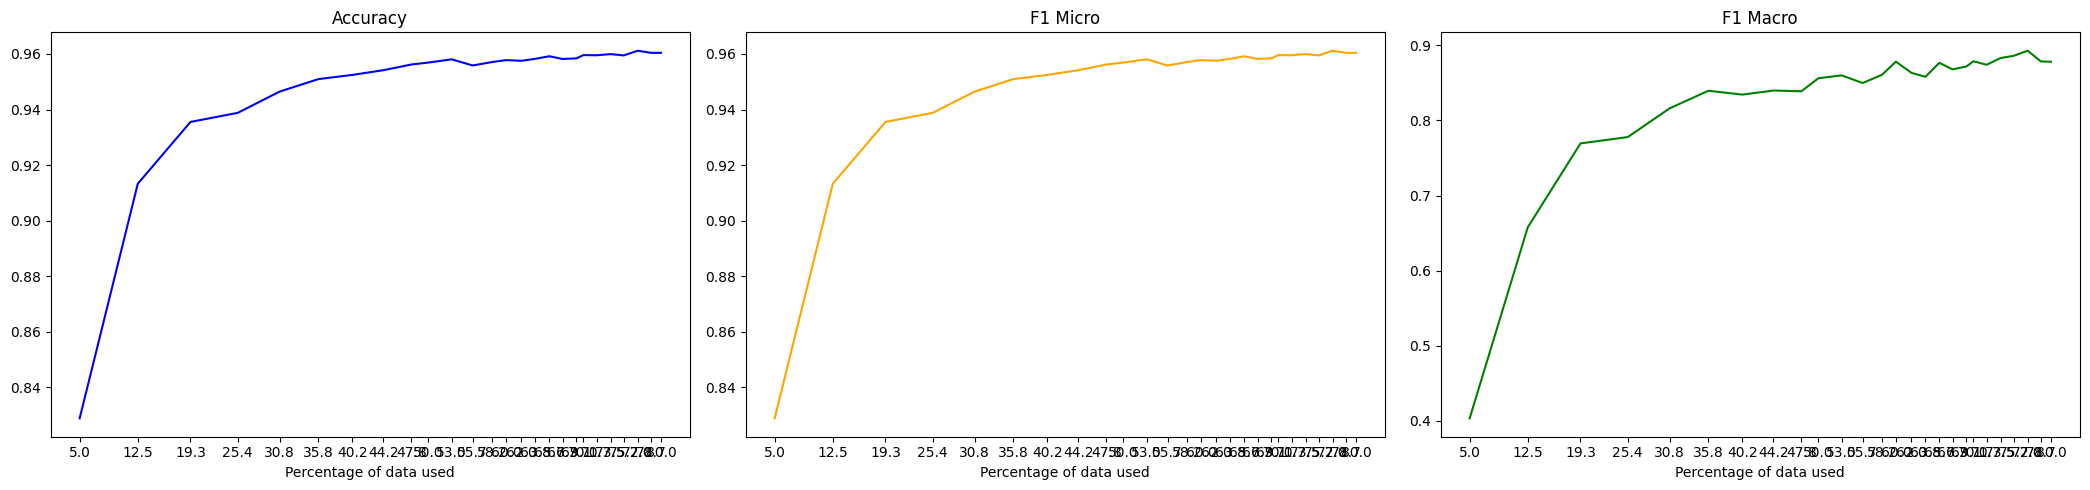

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6258, Accuracy: 0.7997, F1 Micro: 0.8886, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5062, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4506, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Epoch 4/10, Train Loss: 0.4279, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8851
Epoch 5/10, Train Loss: 0.3912, Accuracy: 0.8002, F1 Micro: 0.889, F1 Macro: 0.8843
Epoch 6/10, Train Loss: 0.4012, Accuracy: 0.8024, F1 Micro: 0.8894, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.395, Accuracy: 0.8064, F1 Micro: 0.8911, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3673, Accuracy: 0.8165, F1 Micro: 0.8956, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3431, Accuracy: 0.8281, F1 Micro: 0.901, F1 Macro: 0.8923
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6361, Accuracy: 0.8005, F1 Micro: 0.889, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5025, Accuracy: 0.8021, F1 Micro: 0.8899, F1 Macro: 0.8853
Epoch 3/10, Train Loss: 0.4528, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8851
Epoch 4/10, Train Loss: 0.4265, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.3941, Accuracy: 0.8017, F1 Micro: 0.8898, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3978, Accuracy: 0.804, F1 Micro: 0.8908, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.39, Accuracy: 0.8102, F1 Micro: 0.8933, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.355, Accuracy: 0.8179, F1 Micro: 0.897, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3408, Accuracy: 0.8304, F1 Micro: 0.9028, F1 Macro: 0.8969
Higher F1 achieved, saving mo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6845, Accuracy: 0.7936, F1 Micro: 0.8808, F1 Macro: 0.8559
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5245, Accuracy: 0.8007, F1 Micro: 0.8892, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4576, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4398, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3982, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4086, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4072, Accuracy: 0.8064, F1 Micro: 0.892, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3808, Accuracy: 0.8149, F1 Micro: 0.8956, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5546, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Epoch 2/10, Train Loss: 0.4567, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4333, Accuracy: 0.803, F1 Micro: 0.8904, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.409, Accuracy: 0.8392, F1 Micro: 0.908, F1 Macro: 0.9028
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3744, Accuracy: 0.8668, F1 Micro: 0.922, F1 Macro: 0.9171
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3202, Accuracy: 0.8835, F1 Micro: 0.9314, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2697, Accuracy: 0.8964, F1 Micro: 0.9387, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2369, Accuracy: 0.9165, F1 Micro: 0.9498, F1 Macro: 0.9468
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2089, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5646, Accuracy: 0.8026, F1 Micro: 0.8903, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4554, Accuracy: 0.8028, F1 Micro: 0.8904, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4242, Accuracy: 0.8116, F1 Micro: 0.8945, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.397, Accuracy: 0.8392, F1 Micro: 0.9076, F1 Macro: 0.9016
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3623, Accuracy: 0.8726, F1 Micro: 0.925, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3165, Accuracy: 0.8826, F1 Micro: 0.9308, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2676, Accuracy: 0.8984, F1 Micro: 0.9396, F1 Macro: 0.9357
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2393, Accuracy: 0.9134, F1 Micro: 0.9479, F1 Macro: 0.9444
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5878, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Epoch 2/10, Train Loss: 0.456, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4302, Accuracy: 0.8021, F1 Micro: 0.89, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.411, Accuracy: 0.8314, F1 Micro: 0.9036, F1 Macro: 0.8974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.388, Accuracy: 0.8616, F1 Micro: 0.9191, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.338, Accuracy: 0.8795, F1 Micro: 0.9291, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2928, Accuracy: 0.8863, F1 Micro: 0.933, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2586, Accuracy: 0.9057, F1 Micro: 0.9437, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2284, Accuracy: 0.918

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5193, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4519, Accuracy: 0.8043, F1 Micro: 0.891, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4029, Accuracy: 0.8451, F1 Micro: 0.9114, F1 Macro: 0.9074
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3339, Accuracy: 0.8859, F1 Micro: 0.9327, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2734, Accuracy: 0.9144, F1 Micro: 0.9486, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2232, Accuracy: 0.9288, F1 Micro: 0.9569, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1877, Accuracy: 0.9363, F1 Micro: 0.961, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1692, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9607
Epoch 9/10, Train Loss: 0.1423, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4476, Accuracy: 0.8075, F1 Micro: 0.8926, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3953, Accuracy: 0.8547, F1 Micro: 0.9164, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3248, Accuracy: 0.8835, F1 Micro: 0.9313, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2736, Accuracy: 0.9017, F1 Micro: 0.9415, F1 Macro: 0.9374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.228, Accuracy: 0.9134, F1 Micro: 0.9481, F1 Macro: 0.9444
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1918, Accuracy: 0.9337, F1 Micro: 0.9596, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1701, Accuracy: 0.9365, F1 Micro: 0.9613, F1 Macro: 0.9584
Epoch 9/10, Train Loss: 0.1479, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5435, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4568, Accuracy: 0.8024, F1 Micro: 0.8902, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.412, Accuracy: 0.8319, F1 Micro: 0.9048, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3514, Accuracy: 0.8783, F1 Micro: 0.9286, F1 Macro: 0.9244
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3004, Accuracy: 0.8981, F1 Micro: 0.9395, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.246, Accuracy: 0.9087, F1 Micro: 0.9454, F1 Macro: 0.9423
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2049, Accuracy: 0.9278, F1 Micro: 0.9562, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1799, Accuracy: 0.9391, F1 Micro: 0.9628, F1 Macro: 0.9601
Epoch 9/10, Train Loss: 0.1563, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5185, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4399, Accuracy: 0.8101, F1 Micro: 0.8938, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3814, Accuracy: 0.8743, F1 Micro: 0.9266, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3001, Accuracy: 0.9026, F1 Micro: 0.9421, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2383, Accuracy: 0.9208, F1 Micro: 0.9521, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2001, Accuracy: 0.9326, F1 Micro: 0.9591, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1767, Accuracy: 0.937, F1 Micro: 0.9615, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1477, Accuracy: 0.9415, F1 Micro: 0.9642, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5201, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4294, Accuracy: 0.8253, F1 Micro: 0.9014, F1 Macro: 0.8973
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3591, Accuracy: 0.8839, F1 Micro: 0.9317, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2916, Accuracy: 0.9003, F1 Micro: 0.9409, F1 Macro: 0.937
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2347, Accuracy: 0.9243, F1 Micro: 0.9539, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2012, Accuracy: 0.9342, F1 Micro: 0.96, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1771, Accuracy: 0.942, F1 Micro: 0.9645, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1518, Accuracy: 0.9431, F1 Micro: 0.9652, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5324, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.439, Accuracy: 0.8168, F1 Micro: 0.8971, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3866, Accuracy: 0.8743, F1 Micro: 0.9267, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3145, Accuracy: 0.8976, F1 Micro: 0.9393, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2499, Accuracy: 0.917, F1 Micro: 0.9499, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2104, Accuracy: 0.9332, F1 Micro: 0.9594, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1853, Accuracy: 0.9358, F1 Micro: 0.9607, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.156, Accuracy: 0.9418, F1 Micro: 0.9644, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended premat

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4987, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4293, Accuracy: 0.8351, F1 Micro: 0.9063, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3423, Accuracy: 0.9049, F1 Micro: 0.9431, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2581, Accuracy: 0.934, F1 Micro: 0.9599, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2116, Accuracy: 0.9427, F1 Micro: 0.9649, F1 Macro: 0.9625
Epoch 6/10, Train Loss: 0.1787, Accuracy: 0.9415, F1 Micro: 0.9643, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1465, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1354, Accuracy: 0.9491, F1 Micro: 0.9687, F1 Macro: 0.9659
Epoch 9/10, Train Loss: 0.1192, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5028, Accuracy: 0.8049, F1 Micro: 0.8913, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4212, Accuracy: 0.841, F1 Micro: 0.9092, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3312, Accuracy: 0.8998, F1 Micro: 0.9402, F1 Macro: 0.9359
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2633, Accuracy: 0.929, F1 Micro: 0.9568, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2206, Accuracy: 0.9394, F1 Micro: 0.9631, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1865, Accuracy: 0.9394, F1 Micro: 0.9631, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1519, Accuracy: 0.9448, F1 Micro: 0.9663, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1403, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5148, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4313, Accuracy: 0.8354, F1 Micro: 0.9065, F1 Macro: 0.9024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3521, Accuracy: 0.8972, F1 Micro: 0.9388, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2729, Accuracy: 0.9241, F1 Micro: 0.954, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2238, Accuracy: 0.9392, F1 Micro: 0.963, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1895, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1556, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.144, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4952, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4196, Accuracy: 0.8667, F1 Micro: 0.9217, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3112, Accuracy: 0.9174, F1 Micro: 0.95, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2372, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1848, Accuracy: 0.9441, F1 Micro: 0.9659, F1 Macro: 0.964
Epoch 6/10, Train Loss: 0.1643, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1356, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9679
Epoch 9/10, Train Loss: 0.1058, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4984, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4077, Accuracy: 0.8771, F1 Micro: 0.9272, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3116, Accuracy: 0.9135, F1 Micro: 0.9479, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2421, Accuracy: 0.937, F1 Micro: 0.9614, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1919, Accuracy: 0.9417, F1 Micro: 0.9644, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.9448, F1 Micro: 0.9662, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.14, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1145, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5066, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4196, Accuracy: 0.8707, F1 Micro: 0.9238, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.328, Accuracy: 0.9069, F1 Micro: 0.9443, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2509, Accuracy: 0.9345, F1 Micro: 0.9602, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1975, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1739, Accuracy: 0.945, F1 Micro: 0.9663, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.145, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1197, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4971, Accuracy: 0.8023, F1 Micro: 0.8901, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3984, Accuracy: 0.8894, F1 Micro: 0.9343, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2849, Accuracy: 0.9288, F1 Micro: 0.9569, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2191, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1808, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1528, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1308, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4974, Accuracy: 0.8052, F1 Micro: 0.8915, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3824, Accuracy: 0.8903, F1 Micro: 0.9349, F1 Macro: 0.9298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2798, Accuracy: 0.9293, F1 Micro: 0.957, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2196, Accuracy: 0.942, F1 Micro: 0.9646, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1822, Accuracy: 0.9429, F1 Micro: 0.9652, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1548, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1332, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5099, Accuracy: 0.8043, F1 Micro: 0.8911, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4064, Accuracy: 0.8766, F1 Micro: 0.9275, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3, Accuracy: 0.9205, F1 Micro: 0.952, F1 Macro: 0.9492
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2316, Accuracy: 0.9434, F1 Micro: 0.9654, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1898, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1598, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1361, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1175, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9705
Epoch 9/10, Train Loss: 0.1041, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4895, Accuracy: 0.8141, F1 Micro: 0.8948, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3749, Accuracy: 0.897, F1 Micro: 0.9387, F1 Macro: 0.9346
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2641, Accuracy: 0.9342, F1 Micro: 0.96, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1993, Accuracy: 0.9441, F1 Micro: 0.9657, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1393, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9702
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0942, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4911, Accuracy: 0.8179, F1 Micro: 0.8974, F1 Macro: 0.8921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3665, Accuracy: 0.8906, F1 Micro: 0.9352, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.267, Accuracy: 0.9281, F1 Micro: 0.9566, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2082, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1706, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9695
Epoch 7/10, Train Loss: 0.1249, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9677
Epoch 8/10, Train Loss: 0.1072, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9682
Epoch 9/10, Train Loss: 0.0969, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9688
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5013, Accuracy: 0.8182, F1 Micro: 0.8975, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.387, Accuracy: 0.888, F1 Micro: 0.9339, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2824, Accuracy: 0.9248, F1 Micro: 0.9545, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2141, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1481, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1289, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9705
Epoch 8/10, Train Loss: 0.1132, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1013, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.488, Accuracy: 0.8026, F1 Micro: 0.8903, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3638, Accuracy: 0.8995, F1 Micro: 0.9403, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2515, Accuracy: 0.9385, F1 Micro: 0.9624, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9453, F1 Micro: 0.9664, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1681, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.146, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9689
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0871, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4867, Accuracy: 0.82, F1 Micro: 0.8985, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3567, Accuracy: 0.9016, F1 Micro: 0.9413, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2556, Accuracy: 0.9351, F1 Micro: 0.9603, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.9439, F1 Micro: 0.9656, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1475, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1019, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.498, Accuracy: 0.8163, F1 Micro: 0.8964, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3781, Accuracy: 0.8903, F1 Micro: 0.9351, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2686, Accuracy: 0.9352, F1 Micro: 0.9604, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2101, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1767, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1506, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1082, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.0932, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.478, Accuracy: 0.829, F1 Micro: 0.9014, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.352, Accuracy: 0.9135, F1 Micro: 0.948, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2411, Accuracy: 0.9398, F1 Micro: 0.9632, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4788, Accuracy: 0.8363, F1 Micro: 0.9055, F1 Macro: 0.8982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.345, Accuracy: 0.9071, F1 Micro: 0.9443, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2456, Accuracy: 0.9349, F1 Micro: 0.9603, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9715
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4876, Accuracy: 0.8132, F1 Micro: 0.8954, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3612, Accuracy: 0.9005, F1 Micro: 0.9407, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2572, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1963, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0889, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4823, Accuracy: 0.825, F1 Micro: 0.9013, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3379, Accuracy: 0.922, F1 Micro: 0.9527, F1 Macro: 0.9489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2289, Accuracy: 0.9418, F1 Micro: 0.9644, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9512, F1 Micro: 0.9699, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4806, Accuracy: 0.8349, F1 Micro: 0.9059, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3306, Accuracy: 0.9184, F1 Micro: 0.9507, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2342, Accuracy: 0.9432, F1 Micro: 0.9652, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9524, F1 Micro: 0.9706, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9554, F1 Micro: 0.9726, F1 Macro: 0.9707
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4921, Accuracy: 0.8243, F1 Micro: 0.9009, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3512, Accuracy: 0.9087, F1 Micro: 0.9453, F1 Macro: 0.9419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2461, Accuracy: 0.9422, F1 Micro: 0.9646, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1922, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0846, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4734, Accuracy: 0.8326, F1 Micro: 0.9038, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.334, Accuracy: 0.9266, F1 Micro: 0.9554, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2298, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4701, Accuracy: 0.8378, F1 Micro: 0.9075, F1 Macro: 0.9024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3241, Accuracy: 0.9231, F1 Micro: 0.9533, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2331, Accuracy: 0.9392, F1 Micro: 0.963, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9604, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4837, Accuracy: 0.8273, F1 Micro: 0.9019, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3426, Accuracy: 0.917, F1 Micro: 0.9498, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2414, Accuracy: 0.9378, F1 Micro: 0.9622, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1889, Accuracy: 0.9493, F1 Micro: 0.9688, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.95, F1 Micro: 0.9694, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9559, F1 Micro: 0.9727, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9595, F1 Micro: 0.9751, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4629, Accuracy: 0.8444, F1 Micro: 0.9099, F1 Macro: 0.9035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3186, Accuracy: 0.925, F1 Micro: 0.9544, F1 Macro: 0.9501
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9431, F1 Micro: 0.9651, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9542, F1 Micro: 0.9717, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9729
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4612, Accuracy: 0.8479, F1 Micro: 0.9123, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3155, Accuracy: 0.9226, F1 Micro: 0.953, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9569, F1 Micro: 0.9733, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0733, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.471, Accuracy: 0.8394, F1 Micro: 0.9076, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3321, Accuracy: 0.9134, F1 Micro: 0.9478, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2295, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1897, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1311, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.973
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4757, Accuracy: 0.8358, F1 Micro: 0.9053, F1 Macro: 0.8987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3205, Accuracy: 0.9281, F1 Micro: 0.9564, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.972
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9609, F1 Micro: 0.9757, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9735
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4718, Accuracy: 0.8497, F1 Micro: 0.9125, F1 Macro: 0.9055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3114, Accuracy: 0.9224, F1 Micro: 0.9531, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4858, Accuracy: 0.8326, F1 Micro: 0.9032, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3409, Accuracy: 0.9168, F1 Micro: 0.9499, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2342, Accuracy: 0.9444, F1 Micro: 0.966, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.9465, F1 Micro: 0.9673, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9733
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4748, Accuracy: 0.8564, F1 Micro: 0.9164, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3098, Accuracy: 0.9363, F1 Micro: 0.9611, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9443, F1 Micro: 0.9658, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4681, Accuracy: 0.8748, F1 Micro: 0.9264, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3021, Accuracy: 0.9312, F1 Micro: 0.9581, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.9451, F1 Micro: 0.9665, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.97
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4821, Accuracy: 0.8545, F1 Micro: 0.9156, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3204, Accuracy: 0.9283, F1 Micro: 0.9563, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2254, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4674, Accuracy: 0.8533, F1 Micro: 0.9142, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3061, Accuracy: 0.9323, F1 Micro: 0.9587, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4636, Accuracy: 0.8658, F1 Micro: 0.921, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.303, Accuracy: 0.9285, F1 Micro: 0.9565, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2103, Accuracy: 0.9443, F1 Micro: 0.9658, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.962, F1 Micro: 0.9763, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4737, Accuracy: 0.8547, F1 Micro: 0.9154, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3221, Accuracy: 0.926, F1 Micro: 0.9551, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2176, Accuracy: 0.9451, F1 Micro: 0.9663, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9507, F1 Micro: 0.9698, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0735, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4741, Accuracy: 0.8585, F1 Micro: 0.9171, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2986, Accuracy: 0.9356, F1 Micro: 0.9609, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0719, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4684, Accuracy: 0.8802, F1 Micro: 0.9291, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.294, Accuracy: 0.9288, F1 Micro: 0.957, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.954, F1 Micro: 0.9715, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4834, Accuracy: 0.8601, F1 Micro: 0.9187, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3154, Accuracy: 0.9252, F1 Micro: 0.9549, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9569, F1 Micro: 0.9733, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0734, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4643, Accuracy: 0.8628, F1 Micro: 0.9202, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2888, Accuracy: 0.9321, F1 Micro: 0.9586, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4596, Accuracy: 0.883, F1 Micro: 0.9311, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2861, Accuracy: 0.9292, F1 Micro: 0.9569, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4718, Accuracy: 0.8615, F1 Micro: 0.92, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3066, Accuracy: 0.9229, F1 Micro: 0.9534, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.967, F1 Micro: 0.9795, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4662, Accuracy: 0.862, F1 Micro: 0.9192, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2907, Accuracy: 0.9385, F1 Micro: 0.9626, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9735
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.462, Accuracy: 0.8828, F1 Micro: 0.9304, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.29, Accuracy: 0.9314, F1 Micro: 0.9584, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9644, F1 Micro: 0.9778, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4745, Accuracy: 0.8641, F1 Micro: 0.9206, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3062, Accuracy: 0.9312, F1 Micro: 0.9584, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.949, F1 Micro: 0.9688, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0671, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.462, Accuracy: 0.8674, F1 Micro: 0.9226, F1 Macro: 0.9184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2858, Accuracy: 0.9326, F1 Micro: 0.9591, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9495, F1 Micro: 0.9689, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9739
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4556, Accuracy: 0.887, F1 Micro: 0.933, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2816, Accuracy: 0.9328, F1 Micro: 0.9592, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9556, F1 Micro: 0.9727, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.469, Accuracy: 0.8731, F1 Micro: 0.9258, F1 Macro: 0.9214
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3001, Accuracy: 0.9297, F1 Micro: 0.9574, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9739
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4505, Accuracy: 0.8717, F1 Micro: 0.9243, F1 Macro: 0.9192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2773, Accuracy: 0.9319, F1 Micro: 0.9588, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1903, Accuracy: 0.9512, F1 Micro: 0.9699, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4465, Accuracy: 0.8835, F1 Micro: 0.9313, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2746, Accuracy: 0.9339, F1 Micro: 0.9599, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1923, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9765
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.8729, F1 Micro: 0.9248, F1 Macro: 0.9183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2924, Accuracy: 0.9314, F1 Micro: 0.9584, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0678, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4581, Accuracy: 0.8708, F1 Micro: 0.9237, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2724, Accuracy: 0.9368, F1 Micro: 0.9617, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.197, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4508, Accuracy: 0.8845, F1 Micro: 0.9312, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2715, Accuracy: 0.9321, F1 Micro: 0.9589, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9646, F1 Micro: 0.9779, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4641, Accuracy: 0.8773, F1 Micro: 0.9275, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2878, Accuracy: 0.9321, F1 Micro: 0.9589, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9661, F1 Micro: 0.9789, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9667, F1 Micro: 0.9793, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0656, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4545, Accuracy: 0.8773, F1 Micro: 0.9272, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.9391, F1 Micro: 0.9629, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.976
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.8924, F1 Micro: 0.9358, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.9345, F1 Micro: 0.9603, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9524, F1 Micro: 0.9707, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4622, Accuracy: 0.875, F1 Micro: 0.9259, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2841, Accuracy: 0.9333, F1 Micro: 0.9596, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4476, Accuracy: 0.8715, F1 Micro: 0.925, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2641, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4418, Accuracy: 0.8849, F1 Micro: 0.9322, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2646, Accuracy: 0.9429, F1 Micro: 0.965, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9755
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.455, Accuracy: 0.8802, F1 Micro: 0.9298, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.8773, F1 Micro: 0.928, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.9389, F1 Micro: 0.9626, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.438, Accuracy: 0.8852, F1 Micro: 0.9325, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.9418, F1 Micro: 0.9644, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.9771
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9646, F1 Micro: 0.9781, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4532, Accuracy: 0.8851, F1 Micro: 0.9323, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.9398, F1 Micro: 0.963, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro: 0.9766
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4378, Accuracy: 0.8896, F1 Micro: 0.9344, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.9418, F1 Micro: 0.9646, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1766, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4369, Accuracy: 0.8917, F1 Micro: 0.9356, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2598, Accuracy: 0.9389, F1 Micro: 0.9628, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9509, F1 Micro: 0.9699, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9737
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.057, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model 

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4501, Accuracy: 0.884, F1 Micro: 0.9313, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2692, Accuracy: 0.9398, F1 Micro: 0.9634, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0

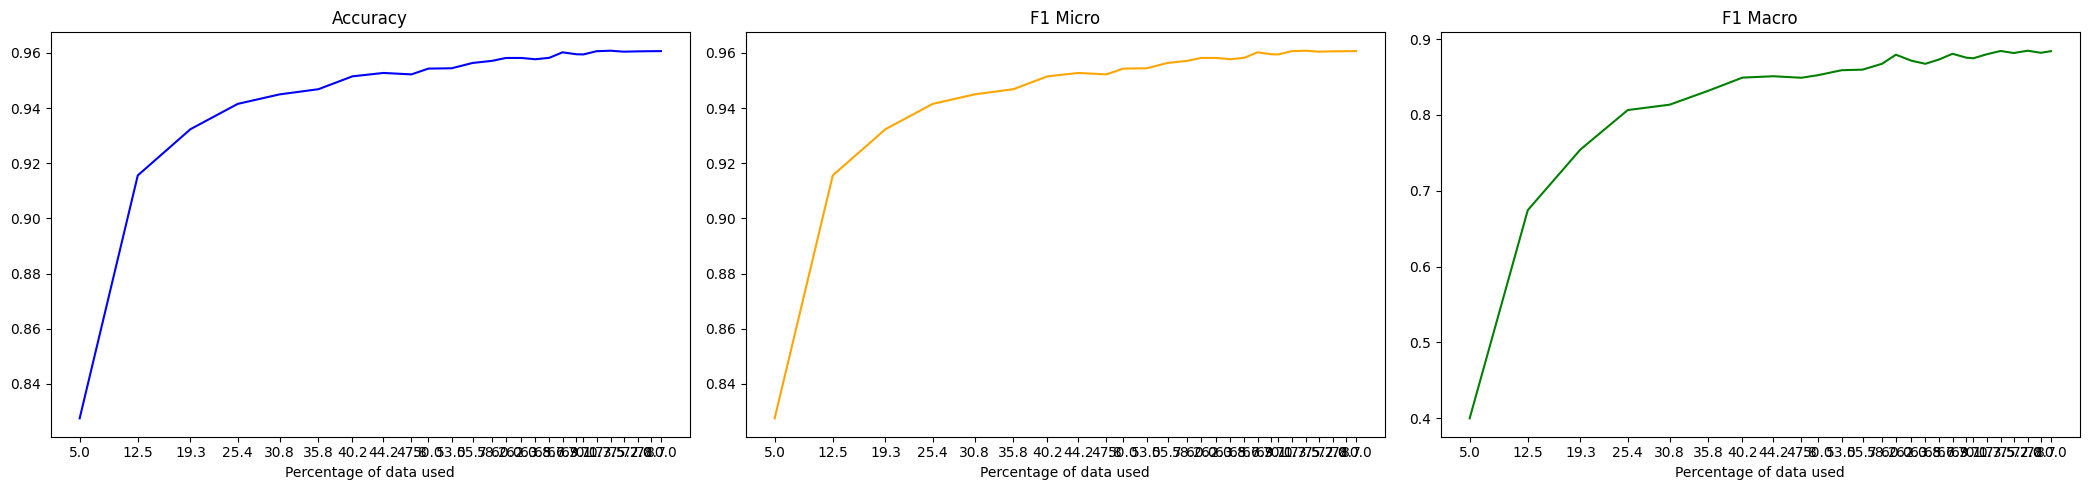

In [ ]:
active_learning(seeds[4], 4)